In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
import sys
import os
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle

''' 레퍼런스
https://spikingjelly.readthedocs.io/zh-cn/0.0.0.0.4/spikingjelly.datasets.html#module-spikingjelly.datasets
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/datasets.py
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/how_to.md
https://github.com/nmi-lab/torchneuromorphic
https://snntorch.readthedocs.io/en/latest/snntorch.spikevision.spikedata.html#shd
'''

import snntorch
from snntorch.spikevision import spikedata

from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from spikingjelly.datasets.n_mnist import NMNIST
# from spikingjelly.datasets.es_imagenet import ESImageNet
from spikingjelly.datasets import split_to_train_test_set
from spikingjelly.datasets.n_caltech101 import NCaltech101
from spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask

import torchneuromorphic

import wandb

from torchviz import make_dot
import graphviz

/tmp/ipykernel_34035/3914466541.py:46: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


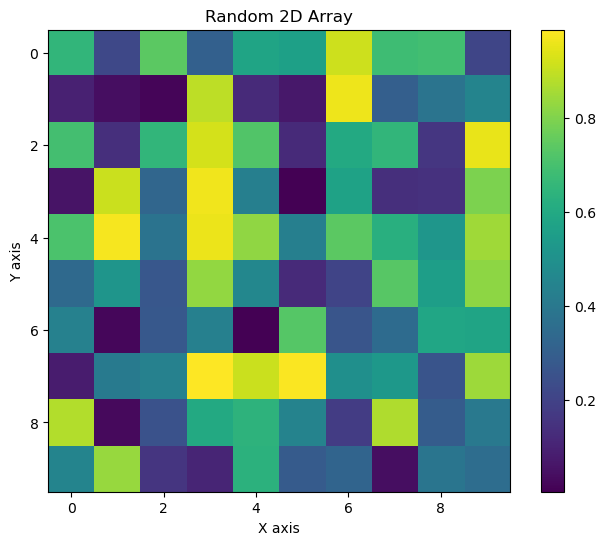

In [3]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [4]:
def my_snn_system(devices = "0,1,2,3",
                    single_step = False, # True # False
                    unique_name = 'main',
                    my_seed = 42,
                    TIME = 10,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on

                    dvs_clipping = True, 
                    dvs_duration = 10005,

                    OTTT_sWS_on = True, # True # False
                  ):
    ## hyperparameter check #############################################################
    if OTTT_sWS_on == True:
        assert BPTT_on == False and tdBN_on == False and convTrue_fcFalse == True
    if single_step == True:
        assert BPTT_on == False and tdBN_on == False 
    if tdBN_on == True:
        assert BPTT_on == False
    if BPTT_on == True:
        assert tdBN_on == False
    if convTrue_fcFalse == False:
        assert OTTT_sWS_on == False
    if pre_trained == True:
        print("\nCaution! pre_trained is True\n")    
    
    print('\nyour OTTT_sWS_on', OTTT_sWS_on,'\n')
    ######################################################################################


    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    hyperparameters['current epoch'] = 0
    ######################################################################################
    
    
    ## DDP settting ######################################################################
    if (ddp_on == True):
        parser = argparse.ArgumentParser(description='my_snn CIFAR10 Training')

        # # local_rank는 command line에서 따로 줄 필요는 없지만, 선언은 필요
        parser.add_argument("--local_rank", default=0, type=int)

        args = parser.parse_args() # 이거 적어줘야됨. parser argument선언하고

        args.gpu = args.local_rank
        torch.cuda.set_device(args.gpu)
        torch.distributed.init_process_group(backend="nccl", init_method="env://")
        args.world_size = torch.distributed.get_world_size()
    #######################################################################################


    ## wandb 세팅 ###################################################################
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    if (ddp_on == True and torch.distributed.get_rank() != 0):
        wandb.finish()
    if (ddp_on == False or torch.distributed.get_rank() == 0):
        wandb.config.update(hyperparameters)
        wandb.run.name = f'lr_{learning_rate}_{unique_name}_{which_data}_tstep{TIME}'
        wandb.define_metric("summary_val_acc", summary="max")
        wandb.run.log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"))
    ###################################################################################



    ## gpu setting ##################################################################################################################
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices
    ###################################################################################################################################


    ## seed setting ##################################################################################################################
    torch.manual_seed(my_seed)
    ###################################################################################################################################
    

    ## data_loader 가져오기 ##################################################################################################################
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on,
            TIME,
            dvs_clipping,
            dvs_duration)
    synapse_fc_out_features = CLASS_NUM
    ###########################################################################################################################################

    
    ## parameter number calculator (안 중요함) ##################################################################################################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'D'):
                    img_size = 1
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            # elif (in_channel == 'M'): #it's a holy FC layer!
            #     img_size = img_size // 2
            else:
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ###########################################################################################################################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ### network setting #######################################################################################################################
    if (convTrue_fcFalse == False):
        if (single_step == False):
            net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on).to(device)
        else:
            net = MY_SNN_FC_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on).to(device)
    else:
        if (single_step == False):
            net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on).to(device)
        else:
            net = MY_SNN_CONV_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on).to(device)
    if (nda_net == True):
        net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                    lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
        net.T = TIME
    if ddp_on == False:
        net = torch.nn.DataParallel(net) 
    
    if pre_trained == True:
        net.load_state_dict(torch.load(f"net_save/save_now_net_weights_{unique_name}.pth"))
    
    if ddp_on == True:
        device = args.gpu
        net = net.to(args.gpu)
        net = DDP(net, delay_allreduce=True)
    else:
        net = net.to(device)


    net = net.to(device)
    if (net_print == True):
        if ddp_on == False or torch.distributed.get_rank() == 0:
            print(net)    
    ####################################################################################################################################
    

    ## wandb logging ###########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        wandb.watch(net, log="all", log_freq = 10) #gradient, parameter logging해줌
    ############################################################

    ## param num and memory estimation except BN with MY own calculation some lines above ##########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
        if (weight_count_print == True):
            for name, param in net.named_parameters():
                if param.requires_grad:
                    print(f'Layer: {name} | Number of parameters: {param.numel()}')
        # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
        # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
        print('='*50)
        print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
        memory = params_num / 8 / 1024 / 1024 # MB
        precision = 32
        memory = memory * precision 
        print(f"Memory: {memory:.2f}MiB at {precision}-bit")
        print('='*50)
    ##############################################################################################################################



    ## criterion ########################################## # loss 구해주는 친구
    criterion = nn.CrossEntropyLoss().to(device)
    if (OTTT_sWS_on == True):
        # criterion = nn.CrossEntropyLoss().to(device)
        criterion = lambda y_t, target_t: ((1 - 0.05) * F.cross_entropy(y_t, target_t) + 0.05 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
    ####################################################
    



    ## optimizer, scheduler ########################################################################
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler
    ## optimizer, scheduler ########################################################################


    tr_acc = 0
    tr_correct = 0
    tr_total = 0
    val_acc = 0
    val_acc_now = 0
    elapsed_time_val = 0
    iter_acc_array = np.array([])
    tr_acc_array = np.array([])
    val_acc_now_array = np.array([])

    #======== EPOCH START ==========================================================================================
    for epoch in range(epoch_num):
        if ddp_on == False or torch.distributed.get_rank() == 0:
            print('EPOCH', epoch)
        epoch_start_time = time.time()

        # if (domain_il_epoch>0 and which_data == 'PMNIST'):
        #     k = epoch // domain_il_epoch
        #     xtrain=data[k]['train']['x']
        #     ytrain=data[k]['train']['y']
        #     xtest =data[k]['test']['x']
        #     ytest =data[k]['test']['y']

        
        ####### iterator : input_loading & tqdm을 통한 progress_bar 생성###################
        iterator = enumerate(train_loader, 0)
        if ddp_on == False or torch.distributed.get_rank() == 0:  
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        ##################################################################################   
        
        #### validation_interval이 batch size보다 작을 시 validation_interval을 batch size로 맞춰줌#############
        validation_interval2 = validation_interval
        if (validation_interval > len(train_loader)):
            validation_interval2 = len(train_loader)
        ##################################################################################################


        ###### ITERATION START ##########################################################################################################
        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train() # train 모드로 바꿔줘야함

            ### data loading & semi-pre-processing ################################################################################
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                # print('x_len',x_len)
                # mask = padded_sequence_mask(x_len)
                # max_time_step = x_len.max()
                # min_time_step = x_len.min()

            ## batch 크기 ######################################
            real_batch = labels.size(0)
            ###########################################################

            ###########################################################################################################################        
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 
                

                
            # # dvs 데이터 시각화 코드 (확인 필요할 시 써라)
            # ##############################################################################################
            # dvs_visualization(inputs, labels, TIME, BATCH)
            # ######################################################################################################



            ## gradient 초기화 #######################################
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            ###########################################################


            if single_step == False:
                # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매##############################
                # inputs: [Time, Batch, Channel, Height, Width]   
                inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
                # inputs: [Batch, Time, Channel, Height, Width] 
                #################################################################################################
            else:
                labels = labels.repeat(TIME, 1)

            

            if single_step == False:
                ### input --> net --> output #####################################################
                outputs = net(inputs)
                ##################################################################################
                ## loss, backward ##########################################
                loss = criterion(outputs, labels)
                loss.backward()
                ############################################################
                ## weight 업데이트!! ##################################
                optimizer.step()
                ################################################################
            else:
                outputs_all = []
                loss = 0.0
                for t in range(TIME):
                    outputs_one_time = net(inputs[t])
                    one_time_loss = criterion(outputs_one_time, labels[t].contiguous())
                    one_time_loss.backward() # one_time backward
                    loss += one_time_loss.data
                    outputs_all.append(outputs_one_time.detach())
                optimizer.step() # full step time update
                outputs_all = torch.stack(outputs_all, dim=1)
                outputs = outputs_all.mean(1) # ottt꺼 쓸때
                labels = labels[0]
                

            ## net 그림 출력해보기 #################################################################
            # print('시각화')
            # make_dot(outputs, params=dict(list(net.named_parameters()))).render("net_torchviz", format="png")
            # return 0
            ##################################################################################

            #### batch 어긋남 방지 ###############################################
            assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
            #######################################################################
            

            ####### training accruacy save for print ###############################
            _, predicted = torch.max(outputs.data, 1)
            total = real_batch
            correct = (predicted == labels).sum().item()
            iter_acc = correct / total
            tr_total += total
            tr_correct += correct
            if i % verbose_interval == verbose_interval-1:
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f'{epoch}-{i} training acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            iter_acc_string = f'{epoch}-{i}/{len(train_loader)} iter:{100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            




            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##################################################################################################################################
            if i % validation_interval2 == validation_interval2-1:
                iter_one_val_time_start = time.time()
                tr_acc = tr_correct/tr_total
                tr_correct = 0
                tr_total = 0
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval() # eval 모드로 바꿔줘야함 
                    for data in test_loader:
                        ## data loading & semi-pre-processing ##########################################################
                        if len(data) == 2:
                            inputs, labels = data
                            # 처리 로직 작성
                        elif len(data) == 3:
                            inputs, labels, x_len = data
                            # print('x_len',x_len)
                            # mask = padded_sequence_mask(x_len)
                            # max_time_step = x_len.max()
                            # min_time_step = x_len.min()
                            # B, T, *spatial_dims = inputs.shape

                        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ###################################################################################################

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        real_batch = labels.size(0)

                        if single_step == False:
                            outputs = net(inputs.permute(1, 0, 2, 3, 4)) #inputs: [Batch, Time, Channel, Height, Width]  
                            val_loss = criterion(outputs, labels)
                        else:
                            val_loss=0
                            outputs_all = []
                            for t in range(TIME):
                                outputs = net(inputs[t])
                                loss = criterion(outputs, labels)
                                outputs_all.append(outputs.detach())
                                val_loss += loss.data
                            outputs_all = torch.stack(outputs_all, dim=1)
                            outputs = outputs_all.mean(1)


                        _, predicted = torch.max(outputs.data, 1)
                        total += real_batch
                        assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
                        correct += (predicted == labels).sum().item()

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc < val_acc_now:
                    val_acc = val_acc_now
                    if ddp_on == False or torch.distributed.get_rank() == 0:
                        # wandb 키면 state_dict아닌거는 저장 안됨
                        torch.save(net.state_dict(), f"net_save/save_now_net_weights_{unique_name}.pth")
                        # torch.save(net, f"net_save/save_now_net_{unique_name}.pth")
                        # torch.save(net.module.state_dict(), f"net_save/save_now_net_weights2_{unique_name}.pth")
                        # torch.save(net.module, f"net_save/save_now_net2_{unique_name}.pth")
            ####################################################################################################################################################
            
            ## progress bar update ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                iterator.set_description(f"{iter_acc_string}, iter_loss:{loss}, val:{100 * val_acc_now:.2f}%, val_best:{100 * val_acc:.2f}%")  
            ####################################################################################################################################
            
            ## wandb logging ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                wandb.log({"iter_acc": iter_acc}, step=i+epoch*len(train_loader))
                wandb.log({"tr_acc": tr_acc}, step=i+epoch*len(train_loader))
                wandb.log({"val_acc_now": val_acc_now}, step=i+epoch*len(train_loader))
                wandb.log({"val_acc_best": val_acc}, step=i+epoch*len(train_loader))
                wandb.log({"summary_val_acc": val_acc_now})
            ####################################################################################################################################
            
            
            ## accuray 로컬에 저장 하기 위한 코드 #####################################################################################
            iter_acc_array = np.append(iter_acc_array, iter_acc)
            tr_acc_array = np.append(tr_acc_array, tr_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            ####################################################################################################################
            
            iter_acc_file_name_time = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
            tr_acc_file_name_time = f'result_save/{base_name}_tr_acc_array_{unique_name}.npy'
            val_acc_file_name_time = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
            hyperparameters_file_name_time = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

            hyperparameters['current epoch'] = epoch

            ### accuracy 세이브: 덮어쓰기 하기 싫으면 주석 풀어서 사용 (시간마다 새로 쓰기) 비추천 ########################
            # if ddp_on == False or torch.distributed.get_rank() == 0:
            #     np.save(iter_acc_file_name_time, iter_acc_array)
            #     np.save(tr_acc_file_name_time, iter_acc_array)
            #     np.save(val_acc_file_name_time, val_acc_now_array)
            #     with open(hyperparameters_file_name_time, 'w') as f:
            #         json.dump(hyperparameters, f, indent=4)
            #########################################################################################################

            ## accuracy 세이브 ###########################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                np.save(f'result_save/iter_acc_array_{unique_name}.npy', iter_acc_array)
                np.save(f'result_save/tr_acc_array_{unique_name}.npy', tr_acc_array)
                np.save(f'result_save/val_acc_now_array_{unique_name}.npy', val_acc_now_array)
                with open(f'result_save/hyperparameters_{unique_name}.json', 'w') as f:
                    json.dump(hyperparameters, f, indent=4)
            ##########################################################################################################
        ###### ITERATION END ##########################################################################################################
                

        ## scheduler update #############################################################################
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        #################################################################################################
        
        # 실행 시간 계산
        epoch_time_end = time.time()
        print(f"epoch_time: {epoch_time_end - epoch_start_time} seconds\n") 
    #======== EPOCH END ==========================================================================================


In [5]:
### my_snn control board ########################
decay = 0.5 # 0.875 0.25 0.125 0.75 0.5
# nda 0.25 # ottt 0.5
unique_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save
run_name = 'main_FINAL_TEST2' ## 이거 설정하면 새로운 경로에 모두 save


wandb.init(project= f'my_snn {unique_name}',save_code=True)

my_snn_system(  devices = "5",
                single_step = True, # True # False
                unique_name = run_name,
                my_seed = 42,
                TIME = 6 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
                BATCH = 128, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = 32, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28
                # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
                #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = 'CIFAR10',
# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# 'DVS_GESTURE','DVS_CIFAR10_2','NMNIST','N_CALTECH101','n_tidigits','heidelberg'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = False, # True # False
                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
                lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
                lif_layer_sg_width = 1.0, # # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1,
                synapse_conv_trace_const2 = decay, # lif_layer_v_decay

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1,
                synapse_fc_trace_const2 = decay, # lif_layer_v_decay

                pre_trained = False, # True # False
                convTrue_fcFalse = True, # True # False

                # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
                # cfg = [64, 64],
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
                # cfg = [], 
                
                net_print = True, # True # False # True로 하길 추천
                weight_count_print = False, # True # False
                
                pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
                learning_rate = 0.1, # default 0.001  # ottt 0.1 0.00001 # nda 0.001 
                epoch_num = 300,
                verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
                validation_interval = 999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

                tdBN_on = False,  # True # False
                BN_on = False,  # True # False
                
                surrogate = 'sigmoid', # 'rectangle' 'sigmoid' 'rough_rectangle'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False 
                # 지원 DATASET: cifar10, mnist

                nda_net = False,   # True # False

                domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
                dvs_clipping = True, # dvs 0 아니면 1만 갖게 하기
                # gesture, cifar-dvs2, nmnist, ncaltech101

                dvs_duration = 10001, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
                #있는 데이터들 #gesture 1000000 #nmnist 10000
                # 한 숫자가 1us인듯 (spikingjelly코드에서)

                OTTT_sWS_on = True, # True # False # BPTT끄고, CONV에만 적용됨.
                
                ) 
# sigmoid와 BN이 있어야 잘된다.
# average pooling
# 이 낫다. 
 
# nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# DDP 실행 코드
'''
ddp_on 키고, gpu 개수 만큼 batch size 나눠줘
CUDA_VISIBLE_DEVICES=0,1,2,3,4,5 python -m torch.distributed.launch --nproc_per_node=6 main_ddp.py
CUDA_VISIBLE_DEVICES=1,2,3 python -m torch.distributed.launch --nproc_per_node=3 main_ddp.py
CUDA_VISIBLE_DEVICES=0,1,2,3 python -m torch.distributed.launch --nproc_per_node=4 main_ddp.py
'''


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin



your OTTT_sWS_on True 

지금 ottt만해라. 아니면 data_loader와서 바꿔라
Files already downloaded and verified
Files already downloaded and verified
DataParallel(
  (module): MY_SNN_CONV_sstep(
    (layers): MY_Sequential(
      (0): SYNAPSE_CONV_trace_sstep()
      (1): LIF_layer_trace_sstep()
      (2): Scale()
      (3): SYNAPSE_CONV_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Scale()
      (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (7): SYNAPSE_CONV_trace_sstep()
      (8): LIF_layer_trace_sstep()
      (9): Scale()
      (10): SYNAPSE_CONV_trace_sstep()
      (11): LIF_layer_trace_sstep()
      (12): Scale()
      (13): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (14): SYNAPSE_CONV_trace_sstep()
      (15): LIF_layer_trace_sstep()
      (16): Scale()
      (17): SYNAPSE_CONV_trace_sstep()
      (18): LIF_layer_trace_sstep()
      (19): Scale()
      (20): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (21): SYNAPSE_CONV_trace_sstep()
      (22): LIF_la

0-390/391 iter:48.75%, lr=['0.1'], iter_loss:0.2135886400938034, val:50.51%, val_best:50.51%: 100%|██████████| 391/391 [02:46<00:00,  2.34it/s]

epoch_time: 167.12155032157898 seconds

EPOCH 1



1-390/391 iter:53.75%, lr=['0.09999725846827562'], iter_loss:0.17726008594036102, val:62.68%, val_best:62.68%: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s]

epoch_time: 169.28329253196716 seconds

EPOCH 2



2-390/391 iter:60.00%, lr=['0.09998903417374229'], iter_loss:0.14504888653755188, val:69.60%, val_best:69.60%: 100%|██████████| 391/391 [02:47<00:00,  2.33it/s]

epoch_time: 167.78032779693604 seconds

EPOCH 3



3-390/391 iter:67.50%, lr=['0.0999753280182866'], iter_loss:0.12365176528692245, val:72.38%, val_best:72.38%: 100%|██████████| 391/391 [02:49<00:00,  2.30it/s]

epoch_time: 169.9817671775818 seconds

EPOCH 4



4-390/391 iter:75.00%, lr=['0.09995614150494293'], iter_loss:0.10100707411766052, val:74.97%, val_best:74.97%: 100%|██████████| 391/391 [02:52<00:00,  2.26it/s]

epoch_time: 172.9301517009735 seconds

EPOCH 5



5-390/391 iter:75.00%, lr=['0.0999314767377287'], iter_loss:0.16275346279144287, val:77.13%, val_best:77.13%: 100%|██████████| 391/391 [02:56<00:00,  2.21it/s]

epoch_time: 177.16085839271545 seconds

EPOCH 6



6-390/391 iter:78.75%, lr=['0.09990133642141359'], iter_loss:0.11851992458105087, val:79.06%, val_best:79.06%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s]

epoch_time: 171.53982973098755 seconds

EPOCH 7



7-390/391 iter:81.25%, lr=['0.0998657238612229'], iter_loss:0.08034574240446091, val:80.31%, val_best:80.31%: 100%|██████████| 391/391 [02:53<00:00,  2.26it/s]

epoch_time: 173.6004364490509 seconds

EPOCH 8



8-390/391 iter:75.00%, lr=['0.09982464296247523'], iter_loss:0.07552379369735718, val:83.12%, val_best:83.12%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s]

epoch_time: 173.9517056941986 seconds

EPOCH 9



9-390/391 iter:80.00%, lr=['0.099778098230154'], iter_loss:0.08589477837085724, val:81.70%, val_best:83.12%: 100%|██████████| 391/391 [02:50<00:00,  2.29it/s]

epoch_time: 170.95567178726196 seconds

EPOCH 10



10-390/391 iter:82.50%, lr=['0.09972609476841367'], iter_loss:0.07943698763847351, val:83.59%, val_best:83.59%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]

epoch_time: 174.98440313339233 seconds

EPOCH 11



11-390/391 iter:88.75%, lr=['0.09966863828001983'], iter_loss:0.07685580104589462, val:83.57%, val_best:83.59%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s]

epoch_time: 171.3639099597931 seconds

EPOCH 12



12-390/391 iter:83.75%, lr=['0.09960573506572391'], iter_loss:0.07803845405578613, val:84.48%, val_best:84.48%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s]

epoch_time: 178.1331388950348 seconds

EPOCH 13



13-390/391 iter:81.25%, lr=['0.09953739202357219'], iter_loss:0.09816395491361618, val:85.55%, val_best:85.55%: 100%|██████████| 391/391 [02:50<00:00,  2.29it/s]

epoch_time: 171.15255904197693 seconds

EPOCH 14



14-390/391 iter:85.00%, lr=['0.09946361664814943'], iter_loss:0.08950620889663696, val:86.22%, val_best:86.22%: 100%|██████████| 391/391 [03:07<00:00,  2.09it/s]

epoch_time: 187.31990242004395 seconds

EPOCH 15



15-390/391 iter:83.75%, lr=['0.0993844170297569'], iter_loss:0.07433535158634186, val:86.33%, val_best:86.33%: 100%|██████████| 391/391 [02:50<00:00,  2.30it/s]

epoch_time: 170.30933046340942 seconds

EPOCH 16



16-390/391 iter:81.25%, lr=['0.09929980185352526'], iter_loss:0.045458100736141205, val:87.36%, val_best:87.36%: 100%|██████████| 391/391 [02:48<00:00,  2.31it/s]

epoch_time: 169.1387825012207 seconds

EPOCH 17



17-390/391 iter:93.75%, lr=['0.0992097803984621'], iter_loss:0.05196225643157959, val:87.21%, val_best:87.36%: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s]

epoch_time: 168.56186771392822 seconds

EPOCH 18



18-390/391 iter:81.25%, lr=['0.09911436253643445'], iter_loss:0.04399604722857475, val:87.26%, val_best:87.36%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s]

epoch_time: 172.54126524925232 seconds

EPOCH 19



19-390/391 iter:91.25%, lr=['0.09901355873108611'], iter_loss:0.0710856020450592, val:87.11%, val_best:87.36%: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s] 

epoch_time: 169.43863153457642 seconds

EPOCH 20



20-390/391 iter:88.75%, lr=['0.09890738003669029'], iter_loss:0.05850186198949814, val:88.56%, val_best:88.56%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]

epoch_time: 174.35628271102905 seconds

EPOCH 21



21-390/391 iter:86.25%, lr=['0.09879583809693737'], iter_loss:0.06477905809879303, val:88.55%, val_best:88.56%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]

epoch_time: 175.6460165977478 seconds

EPOCH 22



22-390/391 iter:91.25%, lr=['0.09867894514365802'], iter_loss:0.04586073383688927, val:88.39%, val_best:88.56%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]

epoch_time: 175.7269299030304 seconds

EPOCH 23



23-390/391 iter:82.50%, lr=['0.09855671399548181'], iter_loss:0.05642841383814812, val:89.30%, val_best:89.30%: 100%|██████████| 391/391 [02:53<00:00,  2.26it/s]

epoch_time: 173.59291100502014 seconds

EPOCH 24



24-390/391 iter:93.75%, lr=['0.09842915805643157'], iter_loss:0.05182875320315361, val:89.33%, val_best:89.33%: 100%|██████████| 391/391 [02:49<00:00,  2.30it/s]

epoch_time: 169.8725824356079 seconds

EPOCH 25



25-390/391 iter:93.75%, lr=['0.09829629131445343'], iter_loss:0.05327557027339935, val:89.41%, val_best:89.41%: 100%|██████████| 391/391 [02:50<00:00,  2.29it/s]

epoch_time: 171.17740106582642 seconds

EPOCH 26



26-390/391 iter:96.25%, lr=['0.09815812833988292'], iter_loss:0.0763097032904625, val:89.78%, val_best:89.78%: 100%|██████████| 391/391 [02:50<00:00,  2.30it/s] 

epoch_time: 170.46978998184204 seconds

EPOCH 27



27-390/391 iter:91.25%, lr=['0.09801468428384717'], iter_loss:0.06483887135982513, val:89.47%, val_best:89.78%: 100%|██████████| 391/391 [02:50<00:00,  2.29it/s]

epoch_time: 170.65911149978638 seconds

EPOCH 28



28-390/391 iter:88.75%, lr=['0.09786597487660338'], iter_loss:0.09925248473882675, val:89.62%, val_best:89.78%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]

epoch_time: 175.02199149131775 seconds

EPOCH 29



29-390/391 iter:92.50%, lr=['0.09771201642581387'], iter_loss:0.07632908225059509, val:89.43%, val_best:89.78%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s]

epoch_time: 171.46057868003845 seconds

EPOCH 30



30-390/391 iter:91.25%, lr=['0.09755282581475772'], iter_loss:0.04264592379331589, val:89.87%, val_best:89.87%: 100%|██████████| 391/391 [02:50<00:00,  2.30it/s]

epoch_time: 170.56775498390198 seconds

EPOCH 31



31-390/391 iter:93.75%, lr=['0.09738842050047931'], iter_loss:0.05697179585695267, val:89.70%, val_best:89.87%: 100%|██████████| 391/391 [02:52<00:00,  2.26it/s]

epoch_time: 173.1446807384491 seconds

EPOCH 32



32-390/391 iter:91.25%, lr=['0.09721881851187408'], iter_loss:0.07275889068841934, val:90.07%, val_best:90.07%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s]

epoch_time: 171.81131410598755 seconds

EPOCH 33



33-390/391 iter:93.75%, lr=['0.0970440384477113'], iter_loss:0.05504594370722771, val:90.09%, val_best:90.09%: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s]

epoch_time: 169.29371905326843 seconds

EPOCH 34



34-390/391 iter:92.50%, lr=['0.0968640994745946'], iter_loss:0.06029734015464783, val:90.60%, val_best:90.60%: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s]

epoch_time: 168.4112274646759 seconds

EPOCH 35



35-390/391 iter:92.50%, lr=['0.0966790213248601'], iter_loss:0.05181387811899185, val:90.81%, val_best:90.81%: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s]

epoch_time: 168.98714685440063 seconds

EPOCH 36



36-390/391 iter:90.00%, lr=['0.09648882429441259'], iter_loss:0.04959334060549736, val:90.38%, val_best:90.81%: 100%|██████████| 391/391 [02:48<00:00,  2.33it/s]

epoch_time: 168.31263375282288 seconds

EPOCH 37



37-390/391 iter:97.50%, lr=['0.09629352924049978'], iter_loss:0.05734100937843323, val:90.80%, val_best:90.81%: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s]

epoch_time: 168.71453166007996 seconds

EPOCH 38



38-390/391 iter:96.25%, lr=['0.09609315757942506'], iter_loss:0.07194708287715912, val:90.64%, val_best:90.81%: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s]

epoch_time: 168.62168169021606 seconds

EPOCH 39



39-390/391 iter:97.50%, lr=['0.09588773128419908'], iter_loss:0.053752124309539795, val:90.56%, val_best:90.81%: 100%|██████████| 391/391 [02:48<00:00,  2.33it/s]

epoch_time: 168.21077632904053 seconds

EPOCH 40



40-390/391 iter:97.50%, lr=['0.09567727288213007'], iter_loss:0.05337577685713768, val:90.93%, val_best:90.93%: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s] 

epoch_time: 169.21102380752563 seconds

EPOCH 41



41-390/391 iter:95.00%, lr=['0.09546180545235346'], iter_loss:0.05915319547057152, val:91.02%, val_best:91.02%: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s] 

epoch_time: 168.8011498451233 seconds

EPOCH 42



42-390/391 iter:98.75%, lr=['0.09524135262330101'], iter_loss:0.04887780174612999, val:91.57%, val_best:91.57%: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s]

epoch_time: 169.55742383003235 seconds

EPOCH 43



43-390/391 iter:92.50%, lr=['0.09501593857010972'], iter_loss:0.047947000712156296, val:91.35%, val_best:91.57%: 100%|██████████| 391/391 [02:47<00:00,  2.33it/s]

epoch_time: 168.12011551856995 seconds

EPOCH 44



44-390/391 iter:96.25%, lr=['0.09478558801197068'], iter_loss:0.056676577776670456, val:91.33%, val_best:91.57%: 100%|██████████| 391/391 [02:47<00:00,  2.33it/s]

epoch_time: 168.12708854675293 seconds

EPOCH 45



45-390/391 iter:93.75%, lr=['0.09455032620941842'], iter_loss:0.06518537551164627, val:91.21%, val_best:91.57%: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s]

epoch_time: 168.56086087226868 seconds

EPOCH 46



46-390/391 iter:93.75%, lr=['0.09431017896156076'], iter_loss:0.03330234810709953, val:91.07%, val_best:91.57%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s] 

epoch_time: 171.37080669403076 seconds

EPOCH 47



47-390/391 iter:98.75%, lr=['0.09406517260324962'], iter_loss:0.06557609885931015, val:91.28%, val_best:91.57%: 100%|██████████| 391/391 [02:47<00:00,  2.33it/s] 

epoch_time: 168.12476778030396 seconds

EPOCH 48



48-390/391 iter:92.50%, lr=['0.09381533400219319'], iter_loss:0.047293614596128464, val:91.03%, val_best:91.57%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]

epoch_time: 174.73166298866272 seconds

EPOCH 49



49-390/391 iter:93.75%, lr=['0.09356069055600949'], iter_loss:0.05187809467315674, val:91.07%, val_best:91.57%: 100%|██████████| 391/391 [02:48<00:00,  2.33it/s]

epoch_time: 168.27270221710205 seconds

EPOCH 50



50-390/391 iter:95.00%, lr=['0.09330127018922195'], iter_loss:0.04227946326136589, val:91.63%, val_best:91.63%: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s]

epoch_time: 168.981609582901 seconds

EPOCH 51



51-390/391 iter:97.50%, lr=['0.0930371013501972'], iter_loss:0.05509928613901138, val:91.40%, val_best:91.63%: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s] 

epoch_time: 168.66597652435303 seconds

EPOCH 52



52-390/391 iter:93.75%, lr=['0.09276821300802535'], iter_loss:0.04195461422204971, val:91.45%, val_best:91.63%: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s] 

epoch_time: 169.556401014328 seconds

EPOCH 53



53-390/391 iter:96.25%, lr=['0.09249463464934321'], iter_loss:0.05724553391337395, val:91.23%, val_best:91.63%: 100%|██████████| 391/391 [02:48<00:00,  2.33it/s] 

epoch_time: 168.33813285827637 seconds

EPOCH 54



54-390/391 iter:97.50%, lr=['0.09221639627510077'], iter_loss:0.05961274728178978, val:91.34%, val_best:91.63%: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s] 

epoch_time: 169.58771920204163 seconds

EPOCH 55



55-390/391 iter:97.50%, lr=['0.09193352839727122'], iter_loss:0.05542811378836632, val:91.70%, val_best:91.70%: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s] 

epoch_time: 169.29984641075134 seconds

EPOCH 56



56-390/391 iter:97.50%, lr=['0.09164606203550499'], iter_loss:0.06294729560613632, val:91.69%, val_best:91.70%: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s] 

epoch_time: 169.22156047821045 seconds

EPOCH 57



57-390/391 iter:97.50%, lr=['0.0913540287137281'], iter_loss:0.04688889533281326, val:91.81%, val_best:91.81%: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s] 

epoch_time: 168.7717308998108 seconds

EPOCH 58



58-390/391 iter:97.50%, lr=['0.09105746045668521'], iter_loss:0.05663519352674484, val:91.99%, val_best:91.99%: 100%|██████████| 391/391 [02:50<00:00,  2.30it/s] 

epoch_time: 170.2697355747223 seconds

EPOCH 59



59-390/391 iter:96.25%, lr=['0.09075638978642771'], iter_loss:0.03162068873643875, val:91.58%, val_best:91.99%: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s] 

epoch_time: 168.82124066352844 seconds

EPOCH 60



60-390/391 iter:98.75%, lr=['0.09045084971874738'], iter_loss:0.0604705773293972, val:91.99%, val_best:91.99%: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s]  

epoch_time: 169.52984929084778 seconds

EPOCH 61



61-390/391 iter:97.50%, lr=['0.09014087375955573'], iter_loss:0.08232801407575607, val:91.77%, val_best:91.99%: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s] 

epoch_time: 168.38858652114868 seconds

EPOCH 62



62-390/391 iter:96.25%, lr=['0.08982649590120982'], iter_loss:0.03258885443210602, val:91.61%, val_best:91.99%: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s] 

epoch_time: 168.61579012870789 seconds

EPOCH 63



63-390/391 iter:97.50%, lr=['0.08950775061878452'], iter_loss:0.050055116415023804, val:92.03%, val_best:92.03%: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s]

epoch_time: 168.78189849853516 seconds

EPOCH 64



64-390/391 iter:98.75%, lr=['0.089184672866292'], iter_loss:0.03243270143866539, val:92.11%, val_best:92.11%: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s] 

epoch_time: 169.65002751350403 seconds

EPOCH 65



65-390/391 iter:93.75%, lr=['0.08885729807284856'], iter_loss:0.04619380831718445, val:91.67%, val_best:92.11%: 100%|██████████| 391/391 [02:52<00:00,  2.26it/s] 

epoch_time: 173.13646697998047 seconds

EPOCH 66



66-390/391 iter:98.75%, lr=['0.08852566213878947'], iter_loss:0.07889474928379059, val:91.65%, val_best:92.11%: 100%|██████████| 391/391 [02:49<00:00,  2.30it/s] 

epoch_time: 170.08166575431824 seconds

EPOCH 67



67-390/391 iter:98.75%, lr=['0.08818980143173213'], iter_loss:0.03657839819788933, val:92.17%, val_best:92.17%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s] 

epoch_time: 172.39450097084045 seconds

EPOCH 68



68-390/391 iter:96.25%, lr=['0.08784975278258783'], iter_loss:0.055860958993434906, val:91.72%, val_best:92.17%: 100%|██████████| 391/391 [02:50<00:00,  2.29it/s]

epoch_time: 171.10565829277039 seconds

EPOCH 69



69-390/391 iter:97.50%, lr=['0.08750555348152299'], iter_loss:0.06763169914484024, val:91.99%, val_best:92.17%: 100%|██████████| 391/391 [02:50<00:00,  2.30it/s] 

epoch_time: 170.2224063873291 seconds

EPOCH 70



70-390/391 iter:96.25%, lr=['0.08715724127386973'], iter_loss:0.035453975200653076, val:91.56%, val_best:92.17%: 100%|██████████| 391/391 [02:50<00:00,  2.29it/s]

epoch_time: 171.13375782966614 seconds

EPOCH 71



71-390/391 iter:96.25%, lr=['0.08680485435598673'], iter_loss:0.058215782046318054, val:91.87%, val_best:92.17%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s]

epoch_time: 172.76545548439026 seconds

EPOCH 72



72-390/391 iter:95.00%, lr=['0.0864484313710706'], iter_loss:0.04500662535429001, val:92.19%, val_best:92.19%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s] 

epoch_time: 172.2472083568573 seconds

EPOCH 73



73-390/391 iter:95.00%, lr=['0.08608801140491813'], iter_loss:0.04922709986567497, val:91.60%, val_best:92.19%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s] 

epoch_time: 175.57579970359802 seconds

EPOCH 74



74-390/391 iter:98.75%, lr=['0.0857236339816402'], iter_loss:0.08774249255657196, val:91.89%, val_best:92.19%: 100%|██████████| 391/391 [03:02<00:00,  2.14it/s] 

epoch_time: 182.58211994171143 seconds

EPOCH 75



75-390/391 iter:93.75%, lr=['0.0853553390593274'], iter_loss:0.04990196228027344, val:91.88%, val_best:92.19%: 100%|██████████| 391/391 [02:59<00:00,  2.18it/s] 

epoch_time: 179.9687557220459 seconds

EPOCH 76



76-390/391 iter:100.00%, lr=['0.08498316702566831'], iter_loss:0.03583153337240219, val:92.33%, val_best:92.33%: 100%|██████████| 391/391 [02:59<00:00,  2.17it/s]

epoch_time: 180.02301716804504 seconds

EPOCH 77



77-390/391 iter:96.25%, lr=['0.08460715869352037'], iter_loss:0.043536003679037094, val:92.10%, val_best:92.33%: 100%|██████████| 391/391 [03:04<00:00,  2.12it/s]

epoch_time: 184.6037197113037 seconds

EPOCH 78



78-390/391 iter:95.00%, lr=['0.08422735529643446'], iter_loss:0.048966825008392334, val:92.30%, val_best:92.33%: 100%|██████████| 391/391 [03:10<00:00,  2.05it/s]

epoch_time: 190.5383095741272 seconds

EPOCH 79



79-390/391 iter:95.00%, lr=['0.08384379848413306'], iter_loss:0.03341167792677879, val:92.54%, val_best:92.54%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s] 

epoch_time: 175.80969977378845 seconds

EPOCH 80



80-390/391 iter:97.50%, lr=['0.08345653031794294'], iter_loss:0.028427161276340485, val:91.98%, val_best:92.54%: 100%|██████████| 391/391 [03:01<00:00,  2.16it/s]

epoch_time: 181.39560532569885 seconds

EPOCH 81



81-390/391 iter:97.50%, lr=['0.08306559326618262'], iter_loss:0.07211916893720627, val:92.27%, val_best:92.54%: 100%|██████████| 391/391 [03:08<00:00,  2.08it/s] 

epoch_time: 188.50054502487183 seconds

EPOCH 82



82-390/391 iter:100.00%, lr=['0.08267103019950531'], iter_loss:0.058086298406124115, val:92.16%, val_best:92.54%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]

epoch_time: 198.94491529464722 seconds

EPOCH 83



83-390/391 iter:97.50%, lr=['0.08227288438619755'], iter_loss:0.03863547742366791, val:92.78%, val_best:92.78%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s] 

epoch_time: 198.4990737438202 seconds

EPOCH 84



84-390/391 iter:96.25%, lr=['0.0818711994874345'], iter_loss:0.049236588180065155, val:92.06%, val_best:92.78%: 100%|██████████| 391/391 [03:27<00:00,  1.89it/s]

epoch_time: 207.36108303070068 seconds

EPOCH 85



85-390/391 iter:100.00%, lr=['0.08146601955249189'], iter_loss:0.03291760012507439, val:92.45%, val_best:92.78%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s]

epoch_time: 199.33041524887085 seconds

EPOCH 86



86-390/391 iter:95.00%, lr=['0.08105738901391554'], iter_loss:0.053713392466306686, val:91.90%, val_best:92.78%: 100%|██████████| 391/391 [03:20<00:00,  1.95it/s]

epoch_time: 201.03527450561523 seconds

EPOCH 87



87-390/391 iter:100.00%, lr=['0.08064535268264884'], iter_loss:0.04793361946940422, val:92.34%, val_best:92.78%: 100%|██████████| 391/391 [03:20<00:00,  1.95it/s]

epoch_time: 200.59868049621582 seconds

EPOCH 88



88-390/391 iter:98.75%, lr=['0.08022995574311877'], iter_loss:0.06330564618110657, val:92.32%, val_best:92.78%: 100%|██████████| 391/391 [03:30<00:00,  1.86it/s] 

epoch_time: 210.25921201705933 seconds

EPOCH 89



89-390/391 iter:100.00%, lr=['0.0798112437482808'], iter_loss:0.03492433577775955, val:92.47%, val_best:92.78%: 100%|██████████| 391/391 [03:44<00:00,  1.74it/s]

epoch_time: 224.62358379364014 seconds

EPOCH 90



90-390/391 iter:98.75%, lr=['0.07938926261462366'], iter_loss:0.04195050522685051, val:92.26%, val_best:92.78%: 100%|██████████| 391/391 [03:28<00:00,  1.87it/s] 

epoch_time: 209.14100694656372 seconds

EPOCH 91



91-390/391 iter:97.50%, lr=['0.07896405861713394'], iter_loss:0.04479173570871353, val:92.15%, val_best:92.78%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s] 

epoch_time: 197.37674975395203 seconds

EPOCH 92



92-390/391 iter:96.25%, lr=['0.0785356783842216'], iter_loss:0.029243405908346176, val:92.48%, val_best:92.78%: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]

epoch_time: 196.90669679641724 seconds

EPOCH 93



93-390/391 iter:97.50%, lr=['0.07810416889260655'], iter_loss:0.036131083965301514, val:92.41%, val_best:92.78%: 100%|██████████| 391/391 [03:24<00:00,  1.91it/s]

epoch_time: 204.59524869918823 seconds

EPOCH 94



94-390/391 iter:96.25%, lr=['0.07766957746216721'], iter_loss:0.03530382364988327, val:92.34%, val_best:92.78%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s] 

epoch_time: 199.72686433792114 seconds

EPOCH 95



95-390/391 iter:97.50%, lr=['0.07723195175075136'], iter_loss:0.061584264039993286, val:92.27%, val_best:92.78%: 100%|██████████| 391/391 [03:22<00:00,  1.93it/s]

epoch_time: 202.46808099746704 seconds

EPOCH 96



96-390/391 iter:98.75%, lr=['0.07679133974894983'], iter_loss:0.05755180865526199, val:92.23%, val_best:92.78%: 100%|██████████| 391/391 [03:22<00:00,  1.94it/s] 

epoch_time: 202.2411322593689 seconds

EPOCH 97



97-390/391 iter:98.75%, lr=['0.07634778977483389'], iter_loss:0.0516468845307827, val:92.56%, val_best:92.78%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]  

epoch_time: 197.89323043823242 seconds

EPOCH 98



98-390/391 iter:100.00%, lr=['0.07590135046865652'], iter_loss:0.059708334505558014, val:92.00%, val_best:92.78%: 100%|██████████| 391/391 [03:15<00:00,  2.00it/s]

epoch_time: 195.42615389823914 seconds

EPOCH 99



99-390/391 iter:100.00%, lr=['0.07545207078751857'], iter_loss:0.0381777286529541, val:92.34%, val_best:92.78%: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s] 

epoch_time: 192.70601177215576 seconds

EPOCH 100



100-390/391 iter:98.75%, lr=['0.07500000000000001'], iter_loss:0.06874634325504303, val:92.37%, val_best:92.78%: 100%|██████████| 391/391 [03:22<00:00,  1.93it/s] 

epoch_time: 202.7655909061432 seconds

EPOCH 101



101-390/391 iter:98.75%, lr=['0.07454518768075706'], iter_loss:0.04743531346321106, val:92.52%, val_best:92.78%: 100%|██████████| 391/391 [03:10<00:00,  2.05it/s] 

epoch_time: 190.92322754859924 seconds

EPOCH 102



102-390/391 iter:100.00%, lr=['0.07408768370508578'], iter_loss:0.0419926643371582, val:92.46%, val_best:92.78%: 100%|██████████| 391/391 [03:08<00:00,  2.08it/s] 

epoch_time: 188.28448128700256 seconds

EPOCH 103



103-390/391 iter:98.75%, lr=['0.07362753824345272'], iter_loss:0.0502886101603508, val:92.61%, val_best:92.78%: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]  

epoch_time: 193.83236145973206 seconds

EPOCH 104



104-390/391 iter:100.00%, lr=['0.07316480175599312'], iter_loss:0.054881975054740906, val:92.24%, val_best:92.78%: 100%|██████████| 391/391 [03:10<00:00,  2.05it/s]

epoch_time: 191.01134490966797 seconds

EPOCH 105



105-390/391 iter:96.25%, lr=['0.07269952498697736'], iter_loss:0.045029692351818085, val:92.59%, val_best:92.78%: 100%|██████████| 391/391 [03:10<00:00,  2.05it/s]

epoch_time: 190.59641933441162 seconds

EPOCH 106



106-390/391 iter:96.25%, lr=['0.0722317589592464'], iter_loss:0.0486508309841156, val:92.64%, val_best:92.78%: 100%|██████████| 391/391 [03:11<00:00,  2.04it/s]  

epoch_time: 191.47662591934204 seconds

EPOCH 107



107-390/391 iter:97.50%, lr=['0.0717615549686164'], iter_loss:0.05113811790943146, val:92.66%, val_best:92.78%: 100%|██████████| 391/391 [03:08<00:00,  2.08it/s] 

epoch_time: 188.4980185031891 seconds

EPOCH 108



108-390/391 iter:97.50%, lr=['0.07128896457825365'], iter_loss:0.05329584330320358, val:92.52%, val_best:92.78%: 100%|██████████| 391/391 [03:05<00:00,  2.11it/s] 

epoch_time: 185.4276988506317 seconds

EPOCH 109



109-390/391 iter:96.25%, lr=['0.07081403961302007'], iter_loss:0.029207058250904083, val:92.54%, val_best:92.78%: 100%|██████████| 391/391 [03:03<00:00,  2.13it/s]

epoch_time: 183.67741680145264 seconds

EPOCH 110



110-390/391 iter:96.25%, lr=['0.07033683215379001'], iter_loss:0.04877166077494621, val:92.36%, val_best:92.78%: 100%|██████████| 391/391 [03:05<00:00,  2.11it/s] 

epoch_time: 185.4040822982788 seconds

EPOCH 111



111-390/391 iter:95.00%, lr=['0.06985739453173903'], iter_loss:0.05274346098303795, val:92.67%, val_best:92.78%: 100%|██████████| 391/391 [03:09<00:00,  2.07it/s] 

epoch_time: 189.2422640323639 seconds

EPOCH 112



112-390/391 iter:98.75%, lr=['0.06937577932260515'], iter_loss:0.04725527763366699, val:92.53%, val_best:92.78%: 100%|██████████| 391/391 [03:03<00:00,  2.13it/s] 

epoch_time: 184.2114713191986 seconds

EPOCH 113



113-390/391 iter:97.50%, lr=['0.06889203934092336'], iter_loss:0.05535489320755005, val:92.70%, val_best:92.78%: 100%|██████████| 391/391 [03:07<00:00,  2.09it/s] 

epoch_time: 187.51456117630005 seconds

EPOCH 114



114-390/391 iter:100.00%, lr=['0.0684062276342339'], iter_loss:0.054983288049697876, val:92.51%, val_best:92.78%: 100%|██████████| 391/391 [03:09<00:00,  2.06it/s]

epoch_time: 190.17538905143738 seconds

EPOCH 115



115-390/391 iter:100.00%, lr=['0.067918397477265'], iter_loss:0.03821858763694763, val:92.63%, val_best:92.78%: 100%|██████████| 391/391 [03:07<00:00,  2.08it/s]

epoch_time: 187.99304747581482 seconds

EPOCH 116



116-390/391 iter:98.75%, lr=['0.06742860236609076'], iter_loss:0.04393305629491806, val:92.53%, val_best:92.78%: 100%|██████████| 391/391 [03:07<00:00,  2.08it/s] 

epoch_time: 188.1965253353119 seconds

EPOCH 117



117-390/391 iter:100.00%, lr=['0.06693689601226457'], iter_loss:0.024418896064162254, val:92.80%, val_best:92.80%: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s]

epoch_time: 201.5342493057251 seconds

EPOCH 118



118-390/391 iter:98.75%, lr=['0.06644333233692916'], iter_loss:0.06612303107976913, val:92.51%, val_best:92.80%: 100%|██████████| 391/391 [03:09<00:00,  2.06it/s] 

epoch_time: 189.8233585357666 seconds

EPOCH 119



119-390/391 iter:100.00%, lr=['0.0659479654649035'], iter_loss:0.07225304841995239, val:92.38%, val_best:92.80%: 100%|██████████| 391/391 [03:04<00:00,  2.11it/s]

epoch_time: 185.13678789138794 seconds

EPOCH 120



120-390/391 iter:93.75%, lr=['0.06545084971874737'], iter_loss:0.05676938593387604, val:92.51%, val_best:92.80%: 100%|██████████| 391/391 [03:02<00:00,  2.14it/s] 

epoch_time: 182.79289555549622 seconds

EPOCH 121



121-390/391 iter:100.00%, lr=['0.06495203961280434'], iter_loss:0.0410875603556633, val:92.86%, val_best:92.86%: 100%|██████████| 391/391 [03:01<00:00,  2.15it/s] 

epoch_time: 182.16771602630615 seconds

EPOCH 122



122-390/391 iter:97.50%, lr=['0.06445158984722359'], iter_loss:0.04575354605913162, val:92.82%, val_best:92.86%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s] 

epoch_time: 172.23580646514893 seconds

EPOCH 123



123-390/391 iter:98.75%, lr=['0.06394955530196147'], iter_loss:0.04029034823179245, val:92.56%, val_best:92.86%: 100%|██████████| 391/391 [02:50<00:00,  2.30it/s] 

epoch_time: 170.53960990905762 seconds

EPOCH 124



124-390/391 iter:98.75%, lr=['0.06344599103076329'], iter_loss:0.052211545407772064, val:92.62%, val_best:92.86%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s]

epoch_time: 171.67484998703003 seconds

EPOCH 125



125-390/391 iter:98.75%, lr=['0.06294095225512605'], iter_loss:0.06087896227836609, val:92.83%, val_best:92.86%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s] 

epoch_time: 172.47660636901855 seconds

EPOCH 126



126-390/391 iter:97.50%, lr=['0.062434494358242734'], iter_loss:0.02897380292415619, val:92.56%, val_best:92.86%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s] 

epoch_time: 172.35564374923706 seconds

EPOCH 127



127-390/391 iter:96.25%, lr=['0.06192667287892904'], iter_loss:0.05541945993900299, val:92.47%, val_best:92.86%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s] 

epoch_time: 172.25468230247498 seconds

EPOCH 128



128-390/391 iter:95.00%, lr=['0.06141754350553279'], iter_loss:0.06404353678226471, val:92.85%, val_best:92.86%: 100%|██████████| 391/391 [02:50<00:00,  2.29it/s] 

epoch_time: 170.88930296897888 seconds

EPOCH 129



129-390/391 iter:100.00%, lr=['0.06090716206982714'], iter_loss:0.05039222165942192, val:92.55%, val_best:92.86%: 100%|██████████| 391/391 [02:50<00:00,  2.29it/s]

epoch_time: 170.83338165283203 seconds

EPOCH 130



130-390/391 iter:98.75%, lr=['0.06039558454088797'], iter_loss:0.06735492497682571, val:92.85%, val_best:92.86%: 100%|██████████| 391/391 [02:50<00:00,  2.29it/s] 

epoch_time: 170.72207736968994 seconds

EPOCH 131



131-390/391 iter:98.75%, lr=['0.059882867018956294'], iter_loss:0.06064426153898239, val:92.85%, val_best:92.86%: 100%|██████████| 391/391 [02:50<00:00,  2.29it/s] 

epoch_time: 171.09281969070435 seconds

EPOCH 132



132-390/391 iter:100.00%, lr=['0.05936906572928624'], iter_loss:0.0429956279695034, val:92.82%, val_best:92.86%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s] 

epoch_time: 171.9513955116272 seconds

EPOCH 133



133-390/391 iter:98.75%, lr=['0.05885423701597917'], iter_loss:0.04795774444937706, val:92.76%, val_best:92.86%: 100%|██████████| 391/391 [02:52<00:00,  2.26it/s] 

epoch_time: 173.02655673027039 seconds

EPOCH 134



134-390/391 iter:98.75%, lr=['0.05833843733580512'], iter_loss:0.051187776029109955, val:92.93%, val_best:92.93%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]

epoch_time: 175.54691910743713 seconds

EPOCH 135



135-390/391 iter:98.75%, lr=['0.057821723252011556'], iter_loss:0.05209147930145264, val:92.55%, val_best:92.93%: 100%|██████████| 391/391 [02:56<00:00,  2.21it/s] 

epoch_time: 177.02119040489197 seconds

EPOCH 136



136-390/391 iter:100.00%, lr=['0.0573041514281206'], iter_loss:0.029447466135025024, val:93.04%, val_best:93.04%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s]

epoch_time: 174.15564894676208 seconds

EPOCH 137



137-390/391 iter:98.75%, lr=['0.05678577862171523'], iter_loss:0.05365442484617233, val:92.76%, val_best:93.04%: 100%|██████████| 391/391 [02:58<00:00,  2.20it/s] 

epoch_time: 178.26573586463928 seconds

EPOCH 138



138-390/391 iter:100.00%, lr=['0.05626666167821522'], iter_loss:0.048502370715141296, val:92.65%, val_best:93.04%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]

epoch_time: 175.78364658355713 seconds

EPOCH 139



139-390/391 iter:100.00%, lr=['0.055746857524643346'], iter_loss:0.04313378781080246, val:92.60%, val_best:93.04%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]

epoch_time: 175.55909299850464 seconds

EPOCH 140



140-390/391 iter:100.00%, lr=['0.0552264231633827'], iter_loss:0.030354347079992294, val:92.77%, val_best:93.04%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]

epoch_time: 175.82803106307983 seconds

EPOCH 141



141-390/391 iter:98.75%, lr=['0.05470541566592574'], iter_loss:0.055605530738830566, val:93.01%, val_best:93.04%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]

epoch_time: 175.65624141693115 seconds

EPOCH 142



142-390/391 iter:100.00%, lr=['0.05418389216661579'], iter_loss:0.03967422991991043, val:92.58%, val_best:93.04%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s]

epoch_time: 177.56202173233032 seconds

EPOCH 143



143-390/391 iter:97.50%, lr=['0.0536619098563816'], iter_loss:0.04096778482198715, val:92.76%, val_best:93.04%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s] 

epoch_time: 174.92994332313538 seconds

EPOCH 144



144-390/391 iter:96.25%, lr=['0.053139525976465686'], iter_loss:0.03495090827345848, val:92.85%, val_best:93.04%: 100%|██████████| 391/391 [02:56<00:00,  2.22it/s] 

epoch_time: 176.46505451202393 seconds

EPOCH 145



145-390/391 iter:95.00%, lr=['0.05261679781214721'], iter_loss:0.04160171002149582, val:92.95%, val_best:93.04%: 100%|██████████| 391/391 [02:51<00:00,  2.27it/s] 

epoch_time: 172.12165594100952 seconds

EPOCH 146



146-390/391 iter:100.00%, lr=['0.05209378268646'], iter_loss:0.06613121181726456, val:92.71%, val_best:93.04%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s]

epoch_time: 171.78286504745483 seconds

EPOCH 147



147-390/391 iter:100.00%, lr=['0.05157053795390641'], iter_loss:0.03963841497898102, val:92.97%, val_best:93.04%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s]

epoch_time: 172.32959699630737 seconds

EPOCH 148



148-390/391 iter:100.00%, lr=['0.051047120994167854'], iter_loss:0.03152468055486679, val:92.83%, val_best:93.04%: 100%|██████████| 391/391 [02:51<00:00,  2.29it/s]

epoch_time: 171.22258758544922 seconds

EPOCH 149



149-390/391 iter:100.00%, lr=['0.0505235892058123'], iter_loss:0.035546839237213135, val:92.92%, val_best:93.04%: 100%|██████████| 391/391 [02:53<00:00,  2.26it/s]

epoch_time: 173.24066734313965 seconds

EPOCH 150



150-390/391 iter:98.75%, lr=['0.05000000000000001'], iter_loss:0.037319283932447433, val:93.25%, val_best:93.25%: 100%|██████████| 391/391 [02:52<00:00,  2.26it/s]

epoch_time: 173.0058081150055 seconds

EPOCH 151



151-390/391 iter:100.00%, lr=['0.04947641079418772'], iter_loss:0.030806247144937515, val:93.07%, val_best:93.25%: 100%|██████████| 391/391 [02:51<00:00,  2.27it/s]

epoch_time: 172.09753561019897 seconds

EPOCH 152



152-390/391 iter:97.50%, lr=['0.04895287900583217'], iter_loss:0.033743903040885925, val:92.82%, val_best:93.25%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s]

epoch_time: 171.75065326690674 seconds

EPOCH 153



153-390/391 iter:97.50%, lr=['0.048429462046093594'], iter_loss:0.03954976424574852, val:93.09%, val_best:93.25%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s] 

epoch_time: 171.63592219352722 seconds

EPOCH 154



154-390/391 iter:98.75%, lr=['0.04790621731354002'], iter_loss:0.027546774595975876, val:93.05%, val_best:93.25%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s]

epoch_time: 171.81099915504456 seconds

EPOCH 155



155-390/391 iter:98.75%, lr=['0.04738320218785281'], iter_loss:0.03302852064371109, val:92.87%, val_best:93.25%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s] 

epoch_time: 172.64512252807617 seconds

EPOCH 156



156-390/391 iter:97.50%, lr=['0.04686047402353434'], iter_loss:0.04660645127296448, val:93.33%, val_best:93.33%: 100%|██████████| 391/391 [02:54<00:00,  2.25it/s] 

epoch_time: 174.2899353504181 seconds

EPOCH 157



157-390/391 iter:98.75%, lr=['0.04633809014361842'], iter_loss:0.04166356474161148, val:92.80%, val_best:93.33%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s] 

epoch_time: 172.67268109321594 seconds

EPOCH 158



158-390/391 iter:97.50%, lr=['0.04581610783338422'], iter_loss:0.04614159092307091, val:93.01%, val_best:93.33%: 100%|██████████| 391/391 [02:53<00:00,  2.26it/s] 

epoch_time: 173.3484983444214 seconds

EPOCH 159



159-390/391 iter:98.75%, lr=['0.045294584334074274'], iter_loss:0.05240888521075249, val:92.95%, val_best:93.33%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s] 

epoch_time: 172.51831793785095 seconds

EPOCH 160



160-390/391 iter:98.75%, lr=['0.044773576836617326'], iter_loss:0.030471399426460266, val:93.01%, val_best:93.33%: 100%|██████████| 391/391 [02:52<00:00,  2.26it/s]

epoch_time: 173.1160867214203 seconds

EPOCH 161



161-390/391 iter:96.25%, lr=['0.044253142475356666'], iter_loss:0.033528417348861694, val:92.92%, val_best:93.33%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]

epoch_time: 174.44326829910278 seconds

EPOCH 162



162-390/391 iter:97.50%, lr=['0.04373333832178478'], iter_loss:0.04017762467265129, val:93.20%, val_best:93.33%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s] 

epoch_time: 172.3848578929901 seconds

EPOCH 163



163-390/391 iter:98.75%, lr=['0.043214221378284776'], iter_loss:0.03955038636922836, val:92.92%, val_best:93.33%: 100%|██████████| 391/391 [02:51<00:00,  2.27it/s] 

epoch_time: 172.0570466518402 seconds

EPOCH 164



164-390/391 iter:98.75%, lr=['0.04269584857187943'], iter_loss:0.05883970111608505, val:92.93%, val_best:93.33%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s] 

epoch_time: 172.04764080047607 seconds

EPOCH 165



165-390/391 iter:100.00%, lr=['0.042178276747988463'], iter_loss:0.05606965348124504, val:92.86%, val_best:93.33%: 100%|██████████| 391/391 [02:52<00:00,  2.26it/s]

epoch_time: 172.90036296844482 seconds

EPOCH 166



166-390/391 iter:98.75%, lr=['0.04166156266419487'], iter_loss:0.030064841732382774, val:92.97%, val_best:93.33%: 100%|██████████| 391/391 [02:52<00:00,  2.26it/s]

epoch_time: 172.82267808914185 seconds

EPOCH 167



167-390/391 iter:100.00%, lr=['0.04114576298402083'], iter_loss:0.05260637030005455, val:93.26%, val_best:93.33%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s]

epoch_time: 172.6411051750183 seconds

EPOCH 168



168-390/391 iter:98.75%, lr=['0.040630934270713764'], iter_loss:0.033063195645809174, val:93.06%, val_best:93.33%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s]

epoch_time: 172.47462844848633 seconds

EPOCH 169



169-390/391 iter:98.75%, lr=['0.040117132981043684'], iter_loss:0.05273156985640526, val:93.22%, val_best:93.33%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s] 

epoch_time: 174.01430821418762 seconds

EPOCH 170



170-390/391 iter:100.00%, lr=['0.03960441545911202'], iter_loss:0.029316823929548264, val:93.11%, val_best:93.33%: 100%|██████████| 391/391 [02:53<00:00,  2.26it/s]

epoch_time: 173.2287962436676 seconds

EPOCH 171



171-390/391 iter:96.25%, lr=['0.03909283793017287'], iter_loss:0.047710686922073364, val:93.05%, val_best:93.33%: 100%|██████████| 391/391 [02:54<00:00,  2.25it/s]

epoch_time: 174.35859537124634 seconds

EPOCH 172



172-390/391 iter:100.00%, lr=['0.03858245649446722'], iter_loss:0.03220087289810181, val:93.14%, val_best:93.33%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s]

epoch_time: 173.97448134422302 seconds

EPOCH 173



173-390/391 iter:96.25%, lr=['0.03807332712107096'], iter_loss:0.0586051270365715, val:93.06%, val_best:93.33%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]  

epoch_time: 174.61409759521484 seconds

EPOCH 174



174-390/391 iter:97.50%, lr=['0.037565505641757264'], iter_loss:0.03200269863009453, val:93.19%, val_best:93.33%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s] 

epoch_time: 174.66447281837463 seconds

EPOCH 175



175-390/391 iter:98.75%, lr=['0.037059047744873966'], iter_loss:0.03896571323275566, val:93.31%, val_best:93.33%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s] 

epoch_time: 175.14610481262207 seconds

EPOCH 176



176-390/391 iter:98.75%, lr=['0.036554008969236725'], iter_loss:0.03155158460140228, val:92.94%, val_best:93.33%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s] 

epoch_time: 174.96008038520813 seconds

EPOCH 177



177-390/391 iter:100.00%, lr=['0.036050444698038524'], iter_loss:0.0360444039106369, val:93.09%, val_best:93.33%: 100%|██████████| 391/391 [02:52<00:00,  2.26it/s] 

epoch_time: 172.87312960624695 seconds

EPOCH 178



178-390/391 iter:98.75%, lr=['0.035548410152776405'], iter_loss:0.04094875603914261, val:93.21%, val_best:93.33%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s] 

epoch_time: 174.40412735939026 seconds

EPOCH 179



179-390/391 iter:98.75%, lr=['0.03504796038719567'], iter_loss:0.04163011163473129, val:92.85%, val_best:93.33%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s] 

epoch_time: 174.18051075935364 seconds

EPOCH 180



180-390/391 iter:100.00%, lr=['0.034549150281252626'], iter_loss:0.04597095772624016, val:93.22%, val_best:93.33%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s]

epoch_time: 173.90118074417114 seconds

EPOCH 181



181-390/391 iter:98.75%, lr=['0.0340520345350965'], iter_loss:0.036247409880161285, val:93.08%, val_best:93.33%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s]

epoch_time: 172.76449346542358 seconds

EPOCH 182



182-390/391 iter:100.00%, lr=['0.03355666766307083'], iter_loss:0.04997244104743004, val:92.96%, val_best:93.33%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s]

epoch_time: 172.50693082809448 seconds

EPOCH 183



183-390/391 iter:98.75%, lr=['0.033063103987735425'], iter_loss:0.041017718613147736, val:93.09%, val_best:93.33%: 100%|██████████| 391/391 [02:51<00:00,  2.28it/s]

epoch_time: 171.77847480773926 seconds

EPOCH 184



184-390/391 iter:100.00%, lr=['0.03257139763390924'], iter_loss:0.04271526634693146, val:92.91%, val_best:93.33%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s]

epoch_time: 173.96567940711975 seconds

EPOCH 185



185-390/391 iter:98.75%, lr=['0.03208160252273499'], iter_loss:0.041594840586185455, val:93.08%, val_best:93.33%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s]

epoch_time: 172.5725073814392 seconds

EPOCH 186



186-390/391 iter:97.50%, lr=['0.031593772365766104'], iter_loss:0.03713146597146988, val:92.96%, val_best:93.33%: 100%|██████████| 391/391 [02:53<00:00,  2.26it/s] 

epoch_time: 173.3408908843994 seconds

EPOCH 187



187-390/391 iter:97.50%, lr=['0.031107960659076627'], iter_loss:0.04318627715110779, val:93.12%, val_best:93.33%: 100%|██████████| 391/391 [02:53<00:00,  2.26it/s] 

epoch_time: 173.56202912330627 seconds

EPOCH 188



188-390/391 iter:98.75%, lr=['0.030624220677394842'], iter_loss:0.056394778192043304, val:93.21%, val_best:93.33%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s]

epoch_time: 172.21889853477478 seconds

EPOCH 189



189-390/391 iter:100.00%, lr=['0.03014260546826095'], iter_loss:0.050139691680669785, val:92.96%, val_best:93.33%: 100%|██████████| 391/391 [02:54<00:00,  2.25it/s]

epoch_time: 174.24110794067383 seconds

EPOCH 190



190-390/391 iter:97.50%, lr=['0.029663167846209974'], iter_loss:0.04672873765230179, val:93.09%, val_best:93.33%: 100%|██████████| 391/391 [02:56<00:00,  2.22it/s] 

epoch_time: 176.38312673568726 seconds

EPOCH 191



191-390/391 iter:98.75%, lr=['0.029185960386979938'], iter_loss:0.054146118462085724, val:93.13%, val_best:93.33%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s]

epoch_time: 174.13056087493896 seconds

EPOCH 192



192-390/391 iter:100.00%, lr=['0.028711035421746356'], iter_loss:0.03828514367341995, val:93.12%, val_best:93.33%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]

epoch_time: 174.46783566474915 seconds

EPOCH 193



193-390/391 iter:98.75%, lr=['0.02823844503138362'], iter_loss:0.04508475586771965, val:93.14%, val_best:93.33%: 100%|██████████| 391/391 [03:00<00:00,  2.16it/s] 

epoch_time: 180.8136022090912 seconds

EPOCH 194



194-390/391 iter:100.00%, lr=['0.027768241040753625'], iter_loss:0.041441917419433594, val:93.20%, val_best:93.33%: 100%|██████████| 391/391 [03:01<00:00,  2.15it/s]

epoch_time: 182.0075569152832 seconds

EPOCH 195



195-390/391 iter:100.00%, lr=['0.02730047501302265'], iter_loss:0.028423672541975975, val:93.11%, val_best:93.33%: 100%|██████████| 391/391 [03:02<00:00,  2.15it/s]

epoch_time: 182.26531553268433 seconds

EPOCH 196



196-390/391 iter:97.50%, lr=['0.026835198244006913'], iter_loss:0.03574448451399803, val:93.19%, val_best:93.33%: 100%|██████████| 391/391 [03:01<00:00,  2.16it/s] 

epoch_time: 181.39318561553955 seconds

EPOCH 197



197-390/391 iter:98.75%, lr=['0.026372461756547293'], iter_loss:0.03674747794866562, val:93.06%, val_best:93.33%: 100%|██████████| 391/391 [03:00<00:00,  2.17it/s] 

epoch_time: 180.37946248054504 seconds

EPOCH 198



198-390/391 iter:100.00%, lr=['0.025912316294914216'], iter_loss:0.0378960520029068, val:92.95%, val_best:93.33%: 100%|██████████| 391/391 [03:02<00:00,  2.14it/s] 

epoch_time: 183.08953046798706 seconds

EPOCH 199



199-390/391 iter:100.00%, lr=['0.025454812319242945'], iter_loss:0.034256551414728165, val:93.14%, val_best:93.33%: 100%|██████████| 391/391 [02:59<00:00,  2.18it/s]

epoch_time: 179.44062328338623 seconds

EPOCH 200



200-390/391 iter:100.00%, lr=['0.024999999999999974'], iter_loss:0.03234979510307312, val:92.93%, val_best:93.33%: 100%|██████████| 391/391 [03:00<00:00,  2.17it/s]

epoch_time: 180.7087152004242 seconds

EPOCH 201



201-390/391 iter:98.75%, lr=['0.02454792921248142'], iter_loss:0.029524769634008408, val:92.92%, val_best:93.33%: 100%|██████████| 391/391 [03:02<00:00,  2.15it/s]

epoch_time: 182.3070695400238 seconds

EPOCH 202



202-390/391 iter:97.50%, lr=['0.024098649531343483'], iter_loss:0.05977163836359978, val:93.07%, val_best:93.33%: 100%|██████████| 391/391 [03:00<00:00,  2.17it/s] 

epoch_time: 180.52415537834167 seconds

EPOCH 203



203-390/391 iter:100.00%, lr=['0.023652210225166108'], iter_loss:0.030016642063856125, val:93.03%, val_best:93.33%: 100%|██████████| 391/391 [03:04<00:00,  2.12it/s]

epoch_time: 184.22539639472961 seconds

EPOCH 204



204-390/391 iter:98.75%, lr=['0.023208660251050166'], iter_loss:0.038178130984306335, val:93.28%, val_best:93.33%: 100%|██████████| 391/391 [03:07<00:00,  2.09it/s]

epoch_time: 187.53218054771423 seconds

EPOCH 205



205-390/391 iter:98.75%, lr=['0.02276804824924865'], iter_loss:0.029933352023363113, val:93.03%, val_best:93.33%: 100%|██████████| 391/391 [02:59<00:00,  2.18it/s]

epoch_time: 179.39818263053894 seconds

EPOCH 206



206-390/391 iter:100.00%, lr=['0.022330422537832784'], iter_loss:0.03959113359451294, val:93.26%, val_best:93.33%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]

epoch_time: 175.08678603172302 seconds

EPOCH 207



207-390/391 iter:100.00%, lr=['0.021895831107393467'], iter_loss:0.031056366860866547, val:93.30%, val_best:93.33%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]

epoch_time: 174.8883240222931 seconds

EPOCH 208



208-390/391 iter:100.00%, lr=['0.021464321615778405'], iter_loss:0.02891457825899124, val:93.26%, val_best:93.33%: 100%|██████████| 391/391 [02:54<00:00,  2.25it/s]

epoch_time: 174.22797346115112 seconds

EPOCH 209



209-390/391 iter:100.00%, lr=['0.021035941382866036'], iter_loss:0.025541013106703758, val:93.06%, val_best:93.33%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]

epoch_time: 175.30972623825073 seconds

EPOCH 210



210-390/391 iter:98.75%, lr=['0.020610737385376332'], iter_loss:0.03470219671726227, val:92.94%, val_best:93.33%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s] 

epoch_time: 175.0393934249878 seconds

EPOCH 211



211-390/391 iter:100.00%, lr=['0.020188756251719186'], iter_loss:0.03533046692609787, val:92.88%, val_best:93.33%: 100%|██████████| 391/391 [02:54<00:00,  2.25it/s]

epoch_time: 174.28740906715393 seconds

EPOCH 212



212-390/391 iter:98.75%, lr=['0.019770044256881242'], iter_loss:0.04736664518713951, val:93.12%, val_best:93.33%: 100%|██████████| 391/391 [02:57<00:00,  2.21it/s] 

epoch_time: 177.24449348449707 seconds

EPOCH 213



213-390/391 iter:100.00%, lr=['0.019354647317351172'], iter_loss:0.044507455080747604, val:92.94%, val_best:93.33%: 100%|██████████| 391/391 [03:01<00:00,  2.15it/s]

epoch_time: 181.6419312953949 seconds

EPOCH 214



214-390/391 iter:98.75%, lr=['0.01894261098608447'], iter_loss:0.04567787051200867, val:93.28%, val_best:93.33%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s] 

epoch_time: 177.5439167022705 seconds

EPOCH 215



215-390/391 iter:100.00%, lr=['0.01853398044750812'], iter_loss:0.035693999379873276, val:92.97%, val_best:93.33%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]

epoch_time: 174.5697009563446 seconds

EPOCH 216



216-390/391 iter:100.00%, lr=['0.018128800512565497'], iter_loss:0.029401784762740135, val:93.07%, val_best:93.33%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]

epoch_time: 174.9850571155548 seconds

EPOCH 217



217-390/391 iter:98.75%, lr=['0.017727115613802465'], iter_loss:0.0452396497130394, val:93.04%, val_best:93.33%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]  

epoch_time: 175.90072679519653 seconds

EPOCH 218



218-390/391 iter:98.75%, lr=['0.017328969800494726'], iter_loss:0.041543252766132355, val:93.20%, val_best:93.33%: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s]

epoch_time: 172.7912940979004 seconds

EPOCH 219



219-390/391 iter:100.00%, lr=['0.01693440673381738'], iter_loss:0.04448145255446434, val:93.25%, val_best:93.33%: 100%|██████████| 391/391 [02:53<00:00,  2.26it/s]

epoch_time: 173.4433789253235 seconds

EPOCH 220



220-390/391 iter:100.00%, lr=['0.016543469682057072'], iter_loss:0.03534030541777611, val:93.09%, val_best:93.33%: 100%|██████████| 391/391 [02:53<00:00,  2.26it/s]

epoch_time: 173.36749696731567 seconds

EPOCH 221



221-390/391 iter:100.00%, lr=['0.016156201515866952'], iter_loss:0.02801605686545372, val:93.23%, val_best:93.33%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]

epoch_time: 174.56572651863098 seconds

EPOCH 222



222-390/391 iter:100.00%, lr=['0.01577264470356555'], iter_loss:0.052793219685554504, val:93.16%, val_best:93.33%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]

epoch_time: 174.96744394302368 seconds

EPOCH 223



223-390/391 iter:97.50%, lr=['0.015392841306479652'], iter_loss:0.03647150844335556, val:93.24%, val_best:93.33%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s] 

epoch_time: 175.80688095092773 seconds

EPOCH 224



224-390/391 iter:98.75%, lr=['0.015016832974331708'], iter_loss:0.05067417025566101, val:93.26%, val_best:93.33%: 100%|██████████| 391/391 [02:55<00:00,  2.22it/s] 

epoch_time: 176.1910104751587 seconds

EPOCH 225



225-390/391 iter:98.75%, lr=['0.014644660940672613'], iter_loss:0.05015904828906059, val:93.34%, val_best:93.34%: 100%|██████████| 391/391 [02:56<00:00,  2.22it/s] 

epoch_time: 176.6549391746521 seconds

EPOCH 226



226-390/391 iter:100.00%, lr=['0.01427636601835983'], iter_loss:0.03248288854956627, val:93.20%, val_best:93.34%: 100%|██████████| 391/391 [02:56<00:00,  2.22it/s]

epoch_time: 176.55152702331543 seconds

EPOCH 227



227-390/391 iter:98.75%, lr=['0.013911988595081878'], iter_loss:0.03702778369188309, val:93.33%, val_best:93.34%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s] 

epoch_time: 175.2115752696991 seconds

EPOCH 228



228-390/391 iter:98.75%, lr=['0.01355156862892942'], iter_loss:0.03833603858947754, val:93.13%, val_best:93.34%: 100%|██████████| 391/391 [03:00<00:00,  2.17it/s] 

epoch_time: 180.58041334152222 seconds

EPOCH 229



229-390/391 iter:100.00%, lr=['0.013195145644013287'], iter_loss:0.03387749195098877, val:93.25%, val_best:93.34%: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]

epoch_time: 193.779639005661 seconds

EPOCH 230



230-390/391 iter:98.75%, lr=['0.01284275872613027'], iter_loss:0.043118905276060104, val:93.25%, val_best:93.34%: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]

epoch_time: 192.78312373161316 seconds

EPOCH 231



231-390/391 iter:100.00%, lr=['0.012494446518477009'], iter_loss:0.04828433319926262, val:93.47%, val_best:93.47%: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]

epoch_time: 193.0059130191803 seconds

EPOCH 232



232-390/391 iter:98.75%, lr=['0.012150247217412175'], iter_loss:0.0472806952893734, val:93.17%, val_best:93.47%: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]  

epoch_time: 193.12375164031982 seconds

EPOCH 233



233-390/391 iter:97.50%, lr=['0.011810198568267876'], iter_loss:0.05994507670402527, val:93.43%, val_best:93.47%: 100%|██████████| 391/391 [03:10<00:00,  2.05it/s] 

epoch_time: 191.16261649131775 seconds

EPOCH 234



234-390/391 iter:100.00%, lr=['0.011474337861210531'], iter_loss:0.048673003911972046, val:93.28%, val_best:93.47%: 100%|██████████| 391/391 [03:11<00:00,  2.04it/s]

epoch_time: 191.78517270088196 seconds

EPOCH 235



235-390/391 iter:100.00%, lr=['0.011142701927151444'], iter_loss:0.029061060398817062, val:93.10%, val_best:93.47%: 100%|██████████| 391/391 [03:11<00:00,  2.04it/s]

epoch_time: 191.62267303466797 seconds

EPOCH 236



236-390/391 iter:100.00%, lr=['0.010815327133708003'], iter_loss:0.04055830091238022, val:93.25%, val_best:93.47%: 100%|██████████| 391/391 [03:08<00:00,  2.08it/s]

epoch_time: 188.60531520843506 seconds

EPOCH 237



237-390/391 iter:100.00%, lr=['0.01049224938121548'], iter_loss:0.037829071283340454, val:93.28%, val_best:93.47%: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]

epoch_time: 197.0026993751526 seconds

EPOCH 238



238-390/391 iter:98.75%, lr=['0.010173504098790176'], iter_loss:0.05447837710380554, val:93.33%, val_best:93.47%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s] 

epoch_time: 199.58207988739014 seconds

EPOCH 239



239-390/391 iter:100.00%, lr=['0.009859126240444271'], iter_loss:0.05245963856577873, val:93.19%, val_best:93.47%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]

epoch_time: 197.24769258499146 seconds

EPOCH 240



240-390/391 iter:100.00%, lr=['0.009549150281252623'], iter_loss:0.062796950340271, val:93.20%, val_best:93.47%: 100%|██████████| 391/391 [03:15<00:00,  2.01it/s]  

epoch_time: 195.3940544128418 seconds

EPOCH 241



241-390/391 iter:100.00%, lr=['0.009243610213572274'], iter_loss:0.039450980722904205, val:93.43%, val_best:93.47%: 100%|██████████| 391/391 [03:14<00:00,  2.01it/s]

epoch_time: 194.79172730445862 seconds

EPOCH 242



242-390/391 iter:100.00%, lr=['0.008942539543314788'], iter_loss:0.02893923781812191, val:93.31%, val_best:93.47%: 100%|██████████| 391/391 [03:10<00:00,  2.05it/s]

epoch_time: 190.8840892314911 seconds

EPOCH 243



243-390/391 iter:98.75%, lr=['0.008645971286271894'], iter_loss:0.03332863748073578, val:93.22%, val_best:93.47%: 100%|██████████| 391/391 [03:15<00:00,  2.00it/s] 

epoch_time: 195.36251521110535 seconds

EPOCH 244



244-390/391 iter:100.00%, lr=['0.008353937964495019'], iter_loss:0.0377182811498642, val:93.32%, val_best:93.47%: 100%|██████████| 391/391 [03:09<00:00,  2.06it/s] 

epoch_time: 189.73150968551636 seconds

EPOCH 245



245-390/391 iter:98.75%, lr=['0.008066471602728794'], iter_loss:0.030452346429228783, val:93.42%, val_best:93.47%: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]

epoch_time: 192.7855532169342 seconds

EPOCH 246



246-390/391 iter:100.00%, lr=['0.007783603724899238'], iter_loss:0.04453708231449127, val:93.18%, val_best:93.47%: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]

epoch_time: 194.08841347694397 seconds

EPOCH 247



247-390/391 iter:98.75%, lr=['0.007505365350656804'], iter_loss:0.04251915216445923, val:93.24%, val_best:93.47%: 100%|██████████| 391/391 [03:12<00:00,  2.04it/s] 

epoch_time: 192.32049751281738 seconds

EPOCH 248



248-390/391 iter:100.00%, lr=['0.007231786991974663'], iter_loss:0.04526015371084213, val:93.32%, val_best:93.47%: 100%|██████████| 391/391 [03:09<00:00,  2.06it/s]

epoch_time: 189.87089896202087 seconds

EPOCH 249



249-390/391 iter:98.75%, lr=['0.006962898649802816'], iter_loss:0.03264999762177467, val:93.35%, val_best:93.47%: 100%|██████████| 391/391 [03:11<00:00,  2.05it/s] 

epoch_time: 191.38567876815796 seconds

EPOCH 250



250-390/391 iter:100.00%, lr=['0.0066987298107780684'], iter_loss:0.031917136162519455, val:93.22%, val_best:93.47%: 100%|██████████| 391/391 [03:11<00:00,  2.04it/s]

epoch_time: 191.92752623558044 seconds

EPOCH 251



251-390/391 iter:100.00%, lr=['0.0064393094439905135'], iter_loss:0.031166784465312958, val:93.34%, val_best:93.47%: 100%|██████████| 391/391 [03:11<00:00,  2.04it/s]

epoch_time: 192.08340048789978 seconds

EPOCH 252



252-390/391 iter:98.75%, lr=['0.006184665997806814'], iter_loss:0.0459892600774765, val:93.23%, val_best:93.47%: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]  

epoch_time: 192.6933193206787 seconds

EPOCH 253



253-390/391 iter:98.75%, lr=['0.005934827396750386'], iter_loss:0.03316836804151535, val:93.33%, val_best:93.47%: 100%|██████████| 391/391 [03:14<00:00,  2.01it/s] 

epoch_time: 195.02839517593384 seconds

EPOCH 254



254-390/391 iter:100.00%, lr=['0.005689821038439258'], iter_loss:0.04633549600839615, val:93.38%, val_best:93.47%: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]

epoch_time: 193.17317843437195 seconds

EPOCH 255



255-390/391 iter:100.00%, lr=['0.005449673790581606'], iter_loss:0.037419453263282776, val:93.38%, val_best:93.47%: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]

epoch_time: 193.89651370048523 seconds

EPOCH 256



256-390/391 iter:98.75%, lr=['0.005214411988029361'], iter_loss:0.04156424105167389, val:93.30%, val_best:93.47%: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s] 

epoch_time: 193.20524430274963 seconds

EPOCH 257



257-390/391 iter:98.75%, lr=['0.004984061429890319'], iter_loss:0.03310587629675865, val:93.25%, val_best:93.47%: 100%|██████████| 391/391 [03:11<00:00,  2.04it/s] 

epoch_time: 191.87672591209412 seconds

EPOCH 258



258-390/391 iter:100.00%, lr=['0.004758647376699027'], iter_loss:0.04551366716623306, val:93.22%, val_best:93.47%: 100%|██████████| 391/391 [03:09<00:00,  2.06it/s]

epoch_time: 189.55691480636597 seconds

EPOCH 259



259-390/391 iter:97.50%, lr=['0.004538194547646569'], iter_loss:0.0310025867074728, val:93.21%, val_best:93.47%: 100%|██████████| 391/391 [03:15<00:00,  2.00it/s]  

epoch_time: 195.880952835083 seconds

EPOCH 260



260-390/391 iter:98.75%, lr=['0.004322727117869958'], iter_loss:0.032688308507204056, val:93.48%, val_best:93.48%: 100%|██████████| 391/391 [03:14<00:00,  2.01it/s]

epoch_time: 194.84084463119507 seconds

EPOCH 261



261-390/391 iter:100.00%, lr=['0.00411226871580095'], iter_loss:0.04101226106286049, val:93.32%, val_best:93.48%: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]

epoch_time: 193.4117555618286 seconds

EPOCH 262



262-390/391 iter:100.00%, lr=['0.003906842420574965'], iter_loss:0.03177144378423691, val:93.35%, val_best:93.48%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]

epoch_time: 198.00499367713928 seconds

EPOCH 263



263-390/391 iter:97.50%, lr=['0.0037064707595002603'], iter_loss:0.036321282386779785, val:93.24%, val_best:93.48%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]

epoch_time: 198.3693449497223 seconds

EPOCH 264



264-390/391 iter:98.75%, lr=['0.0035111757055874297'], iter_loss:0.044621922075748444, val:93.32%, val_best:93.48%: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]

epoch_time: 196.77262568473816 seconds

EPOCH 265



265-390/391 iter:100.00%, lr=['0.00332097867513991'], iter_loss:0.04689505696296692, val:93.27%, val_best:93.48%: 100%|██████████| 391/391 [03:09<00:00,  2.06it/s]

epoch_time: 189.96269536018372 seconds

EPOCH 266



266-390/391 iter:98.75%, lr=['0.003135900525405425'], iter_loss:0.05129241943359375, val:93.37%, val_best:93.48%: 100%|██████████| 391/391 [03:10<00:00,  2.06it/s] 

epoch_time: 190.3445007801056 seconds

EPOCH 267



267-390/391 iter:100.00%, lr=['0.002955961552288725'], iter_loss:0.0518951341509819, val:93.33%, val_best:93.48%: 100%|██████████| 391/391 [03:09<00:00,  2.06it/s] 

epoch_time: 190.19761681556702 seconds

EPOCH 268



268-390/391 iter:100.00%, lr=['0.0027811814881259483'], iter_loss:0.03809336945414543, val:93.37%, val_best:93.48%: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]

epoch_time: 193.13921189308167 seconds

EPOCH 269



269-390/391 iter:97.50%, lr=['0.0026115794995207205'], iter_loss:0.03538937866687775, val:93.21%, val_best:93.48%: 100%|██████████| 391/391 [03:01<00:00,  2.15it/s] 

epoch_time: 182.1078643798828 seconds

EPOCH 270



270-390/391 iter:100.00%, lr=['0.002447174185242322'], iter_loss:0.06017511337995529, val:93.18%, val_best:93.48%: 100%|██████████| 391/391 [03:01<00:00,  2.15it/s]

epoch_time: 181.87393593788147 seconds

EPOCH 271



271-390/391 iter:98.75%, lr=['0.0022879835741861573'], iter_loss:0.054074324667453766, val:93.20%, val_best:93.48%: 100%|██████████| 391/391 [03:06<00:00,  2.10it/s]

epoch_time: 186.32429313659668 seconds

EPOCH 272



272-390/391 iter:98.75%, lr=['0.0021340251233966366'], iter_loss:0.05913287401199341, val:93.30%, val_best:93.48%: 100%|██████████| 391/391 [03:06<00:00,  2.10it/s] 

epoch_time: 186.71305799484253 seconds

EPOCH 273



273-390/391 iter:100.00%, lr=['0.0019853157161528454'], iter_loss:0.03570467233657837, val:93.29%, val_best:93.48%: 100%|██████████| 391/391 [03:06<00:00,  2.09it/s]

epoch_time: 186.89330577850342 seconds

EPOCH 274



274-390/391 iter:100.00%, lr=['0.0018418716601170937'], iter_loss:0.02962169423699379, val:93.32%, val_best:93.48%: 100%|██████████| 391/391 [02:58<00:00,  2.19it/s]

epoch_time: 178.6055769920349 seconds

EPOCH 275



275-390/391 iter:100.00%, lr=['0.0017037086855465834'], iter_loss:0.05525648593902588, val:93.44%, val_best:93.48%: 100%|██████████| 391/391 [03:06<00:00,  2.10it/s]

epoch_time: 186.50012612342834 seconds

EPOCH 276



276-390/391 iter:100.00%, lr=['0.0015708419435684453'], iter_loss:0.0478796623647213, val:93.24%, val_best:93.48%: 100%|██████████| 391/391 [03:06<00:00,  2.09it/s] 

epoch_time: 186.9435429573059 seconds

EPOCH 277



277-390/391 iter:100.00%, lr=['0.0014432860045182007'], iter_loss:0.04352136701345444, val:93.22%, val_best:93.48%: 100%|██████████| 391/391 [03:10<00:00,  2.05it/s]

epoch_time: 190.8991298675537 seconds

EPOCH 278



278-390/391 iter:98.75%, lr=['0.0013210548563419846'], iter_loss:0.05162660777568817, val:93.25%, val_best:93.48%: 100%|██████████| 391/391 [03:11<00:00,  2.05it/s] 

epoch_time: 191.1880965232849 seconds

EPOCH 279



279-390/391 iter:100.00%, lr=['0.001204161903062633'], iter_loss:0.037641629576683044, val:93.33%, val_best:93.48%: 100%|██████████| 391/391 [03:06<00:00,  2.10it/s]

epoch_time: 186.40930151939392 seconds

EPOCH 280



280-390/391 iter:98.75%, lr=['0.0010926199633097202'], iter_loss:0.050620585680007935, val:93.26%, val_best:93.48%: 100%|██████████| 391/391 [03:05<00:00,  2.10it/s]

epoch_time: 186.00313878059387 seconds

EPOCH 281



281-390/391 iter:100.00%, lr=['0.0009864412689139115'], iter_loss:0.035916395485401154, val:93.29%, val_best:93.48%: 100%|██████████| 391/391 [03:07<00:00,  2.08it/s]

epoch_time: 187.99811100959778 seconds

EPOCH 282



282-390/391 iter:100.00%, lr=['0.0008856374635655687'], iter_loss:0.046002503484487534, val:93.30%, val_best:93.48%: 100%|██████████| 391/391 [03:09<00:00,  2.07it/s]

epoch_time: 189.5828628540039 seconds

EPOCH 283



283-390/391 iter:98.75%, lr=['0.0007902196015379052'], iter_loss:0.050838395953178406, val:93.36%, val_best:93.48%: 100%|██████████| 391/391 [03:03<00:00,  2.13it/s]

epoch_time: 184.0905156135559 seconds

EPOCH 284



284-390/391 iter:100.00%, lr=['0.0007001981464747503'], iter_loss:0.03615586832165718, val:93.26%, val_best:93.48%: 100%|██████████| 391/391 [03:06<00:00,  2.10it/s]

epoch_time: 186.70416116714478 seconds

EPOCH 285



285-390/391 iter:100.00%, lr=['0.0006155829702431165'], iter_loss:0.0492246076464653, val:93.31%, val_best:93.48%: 100%|██████████| 391/391 [03:07<00:00,  2.08it/s] 

epoch_time: 187.92464447021484 seconds

EPOCH 286



286-390/391 iter:100.00%, lr=['0.0005363833518505828'], iter_loss:0.06050555408000946, val:93.39%, val_best:93.48%: 100%|██████████| 391/391 [03:01<00:00,  2.15it/s]

epoch_time: 181.7484586238861 seconds

EPOCH 287



287-390/391 iter:100.00%, lr=['0.00046260797642781965'], iter_loss:0.04625507444143295, val:93.28%, val_best:93.48%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]

epoch_time: 175.68923330307007 seconds

EPOCH 288



288-390/391 iter:100.00%, lr=['0.00039426493427611135'], iter_loss:0.039829473942518234, val:93.38%, val_best:93.48%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s]

epoch_time: 177.6907994747162 seconds

EPOCH 289



289-390/391 iter:100.00%, lr=['0.0003313617199801774'], iter_loss:0.03399520739912987, val:93.34%, val_best:93.48%: 100%|██████████| 391/391 [02:56<00:00,  2.22it/s]

epoch_time: 176.67226195335388 seconds

EPOCH 290



290-390/391 iter:98.75%, lr=['0.00027390523158633525'], iter_loss:0.043986864387989044, val:93.39%, val_best:93.48%: 100%|██████████| 391/391 [02:53<00:00,  2.25it/s]

epoch_time: 174.12425231933594 seconds

EPOCH 291



291-390/391 iter:98.75%, lr=['0.00022190176984599998'], iter_loss:0.043747007846832275, val:93.33%, val_best:93.48%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]

epoch_time: 174.95782279968262 seconds

EPOCH 292



292-390/391 iter:98.75%, lr=['0.0001753570375247813'], iter_loss:0.055004291236400604, val:93.43%, val_best:93.48%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]

epoch_time: 174.74514842033386 seconds

EPOCH 293



293-390/391 iter:100.00%, lr=['0.00013427613877709508'], iter_loss:0.05608278512954712, val:93.28%, val_best:93.48%: 100%|██████████| 391/391 [02:54<00:00,  2.24it/s]

epoch_time: 174.58860182762146 seconds

EPOCH 294



294-390/391 iter:100.00%, lr=['9.866357858642196e-05'], iter_loss:0.05062735080718994, val:93.33%, val_best:93.48%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]

epoch_time: 175.43542528152466 seconds

EPOCH 295



295-390/391 iter:98.75%, lr=['6.852326227130828e-05'], iter_loss:0.06198456138372421, val:93.47%, val_best:93.48%: 100%|██████████| 391/391 [02:56<00:00,  2.22it/s] 

epoch_time: 176.3381814956665 seconds

EPOCH 296



296-390/391 iter:100.00%, lr=['4.38584950570808e-05'], iter_loss:0.04607526212930679, val:93.35%, val_best:93.48%: 100%|██████████| 391/391 [02:55<00:00,  2.23it/s]

epoch_time: 175.41656923294067 seconds

EPOCH 297



297-390/391 iter:100.00%, lr=['2.4671981713419976e-05'], iter_loss:0.06635455787181854, val:93.44%, val_best:93.48%: 100%|██████████| 391/391 [02:56<00:00,  2.21it/s]

epoch_time: 177.03197979927063 seconds

EPOCH 298



298-390/391 iter:98.75%, lr=['1.096582625772501e-05'], iter_loss:0.04499544948339462, val:93.38%, val_best:93.48%: 100%|██████████| 391/391 [02:56<00:00,  2.21it/s] 

epoch_time: 177.09663486480713 seconds

EPOCH 299



299-390/391 iter:100.00%, lr=['2.7415317243928406e-06'], iter_loss:0.05502836033701897, val:93.47%, val_best:93.48%: 100%|██████████| 391/391 [02:55<00:00,  2.22it/s]

epoch_time: 176.13760232925415 seconds



'\nddp_on 키고, gpu 개수 만큼 batch size 나눠줘\nCUDA_VISIBLE_DEVICES=0,1,2,3,4,5 python -m torch.distributed.launch --nproc_per_node=6 main_ddp.py\nCUDA_VISIBLE_DEVICES=1,2,3 python -m torch.distributed.launch --nproc_per_node=3 main_ddp.py\nCUDA_VISIBLE_DEVICES=0,1,2,3 python -m torch.distributed.launch --nproc_per_node=4 main_ddp.py\n'

In [6]:
# # sweep 하는 코드, 위 셀 주석처리 해야 됨.

# unique_name_hyper = 'main'
# run_name = 'main'
# sweep_configuration = {
#     'method': 'bayes',
#     'name': 'my_snn_sweep',
#     'metric': {'goal': 'maximize', 'name': 'val_acc_now'},
#     'parameters': 
#     {
#         "learning_rate": {"values": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]},
#         "batch_size": {"values": [64, 96, 128]},
#         "decay": {"values": [0.3,0.4,0.5,0.6,0.7,0.8,0.875,0.9]},
#      }
# }

# def hyper_iter():
#     ### my_snn control board ########################
#     unique_name = unique_name_hyper ## 이거 설정하면 새로운 경로에 모두 save
    
#     wandb.init(save_code = True)
#     learning_rate  =  wandb.config.learning_rate
#     batch_size  =  wandb.config.batch_size
#     decay  =  wandb.config.decay

#     my_snn_system(  devices = "3",
#                     single_step = True, # True # False
#                     unique_name = run_name,
#                     my_seed = 42,
#                     TIME = 6 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
#                     BATCH = batch_size, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
#                     IMAGE_SIZE = 32, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28
#                     # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
#                     #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

#                     # DVS_CIFAR10 할거면 time 10으로 해라
#                     which_data = 'CIFAR10',
#     # 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
#     # 'DVS_GESTURE','DVS_CIFAR10_2','NMNIST','N_CALTECH101','n_tidigits','heidelberg'
#                     # CLASS_NUM = 10,
#                     data_path = '/data2', # YOU NEED TO CHANGE THIS
#                     rate_coding = False, # True # False

#                     lif_layer_v_init = 0.0,
#                     lif_layer_v_decay = decay,
#                     lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
#                     lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
#                     lif_layer_sg_width = 1.0, # # surrogate sigmoid 쓸 때는 의미없음

#                     # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
#                     synapse_conv_kernel_size = 3,
#                     synapse_conv_stride = 1,
#                     synapse_conv_padding = 1,
#                     synapse_conv_trace_const1 = 1,
#                     synapse_conv_trace_const2 = decay, # lif_layer_v_decay

#                     # synapse_fc_out_features = CLASS_NUM,
#                     synapse_fc_trace_const1 = 1,
#                     synapse_fc_trace_const2 = decay, # lif_layer_v_decay

#                     pre_trained = False, # True # False
#                     convTrue_fcFalse = True, # True # False

#                     # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
#                     # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
#                     # cfg = [64],
#                     # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
#                     cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
#                     # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], #ottt
#                     # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], # ottt 
#                     # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
#                     # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
#                     # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
#                     # cfg = [20001,10001], # depthwise, separable
#                     # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
#                     # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
#                     # cfg = [], 
                    
#                     net_print = True, # True # False
#                     weight_count_print = False, # True # False
                    
#                     pre_trained_path = f"net_save/save_now_net_{unique_name}.pth",
#                     learning_rate = learning_rate, # default 0.001  # ottt 0.1 0.00001 # nda 0.001 
#                     epoch_num = 4,
#                     verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
#                     validation_interval = 999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

#                     tdBN_on = False,  # True # False
#                     BN_on = False,  # True # False
                    
#                     surrogate = 'sigmoid', # 'rectangle' 'sigmoid' 'rough_rectangle'
                    
#                     gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

#                     BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
#                     optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
#                     scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                    
#                     ddp_on = False,   # True # False

#                     nda_net = False,   # True # False

#                     domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                    
#                     dvs_clipping = True, # dvs zero&one  # gesture, cifar-dvs2, nmnist, ncaltech101
#                     dvs_duration = 1000000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
#                     #있는 데이터들 #gesture 1000000 #nmnist 10000

#                     OTTT_sWS_on = True, # True # False # BPTT끄고, CONV에만 적용됨.
                    
#                     ) 
#     # sigmoid와 BN이 있어야 잘된다.
#     # average pooling
#     # 이 낫다. 
    
#     # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
#     ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'my_snn {unique_name_hyper}')
# wandb.agent(sweep_id, function=hyper_iter, count=1000)


In [ ]:
wandb.finish()

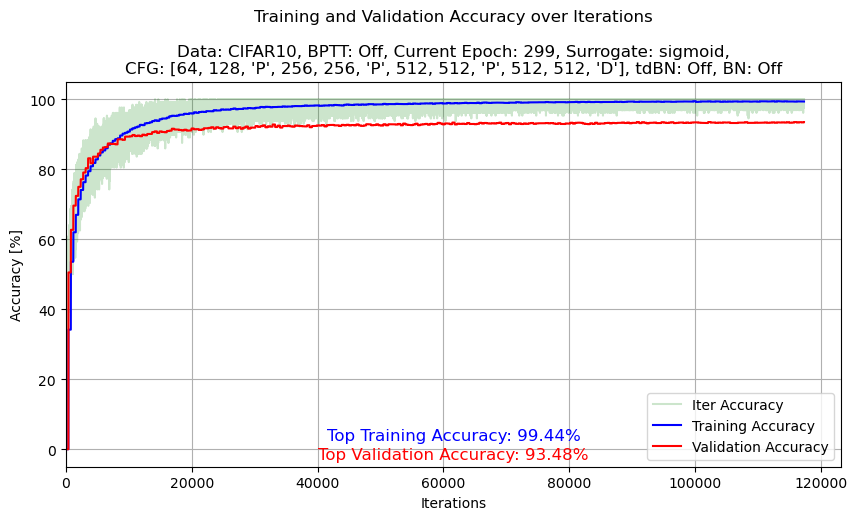

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import json
run_name = 'main_FINAL_TEST2'

unique_name = run_name
def pad_array_to_match_length(array1, array2):
    if len(array1) > len(array2):
        padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
        return array1, padded_array2
    elif len(array2) > len(array1):
        padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
        return padded_array1, array2
    else:
        return array1, array2
def load_hyperparameters(filename=f'result_save/hyperparameters_{unique_name}.json'):
    with open(filename, 'r') as f:
        return json.load(f)
    




current_time = '20240628_110116'
base_name = f'{current_time}'
iter_acc_file_name = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
val_acc_file_name = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
hyperparameters_file_name = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

### if you want to just see most recent train and val acc###########################
iter_acc_file_name = f'result_save/iter_acc_array_{unique_name}.npy'
tr_acc_file_name = f'result_save/tr_acc_array_{unique_name}.npy'
val_acc_file_name = f'result_save/val_acc_now_array_{unique_name}.npy'
hyperparameters_file_name = f'result_save/hyperparameters_{unique_name}.json'

loaded_iter_acc_array = np.load(iter_acc_file_name)*100
loaded_tr_acc_array = np.load(tr_acc_file_name)*100
loaded_val_acc_array = np.load(val_acc_file_name)*100
hyperparameters = load_hyperparameters(hyperparameters_file_name)

loaded_iter_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_val_acc_array)
loaded_iter_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_tr_acc_array)
loaded_val_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_val_acc_array, loaded_tr_acc_array)

top_iter_acc = np.max(loaded_iter_acc_array)
top_tr_acc = np.max(loaded_tr_acc_array)
top_val_acc = np.max(loaded_val_acc_array)

which_data = hyperparameters['which_data']
BPTT_on = hyperparameters['BPTT_on']
current_epoch = hyperparameters['current epoch']
surrogate = hyperparameters['surrogate']
cfg = hyperparameters['cfg']
tdBN_on = hyperparameters['tdBN_on']
BN_on = hyperparameters['BN_on']


iterations = np.arange(len(loaded_iter_acc_array))

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(iterations, loaded_iter_acc_array, label='Iter Accuracy', color='g', alpha=0.2)
plt.plot(iterations, loaded_tr_acc_array, label='Training Accuracy', color='b')
plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# # 텍스트 추가
# plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_iter_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
# plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')
# 텍스트 추가
plt.text(0.5, 0.10, f'Top Training Accuracy: {top_tr_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')
plt.text(0.5, 0.05, f'Top Validation Accuracy: {top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

plt.xlabel('Iterations')
plt.ylabel('Accuracy [%]')

# 그래프 제목에 하이퍼파라미터 정보 추가
title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

plt.title(title)

plt.legend(loc='lower right')
plt.xlim(0)  # x축을 0부터 시작
plt.grid(True)
plt.show()

In [11]:
wandb.finish()

iter_acc,▁▄▅▅▆▇▇▇██▇▇▇████▇█▇█████████████▇██████
summary_val_acc,▁▅▆▇▇▇▇▇████████████████████████████████
tr_acc,▁▄▆▇▇▇▇█████████████████████████████████
val_acc_best,▁▅▆▇▇▇██████████████████████████████████
val_acc_now,▁▅▆▇▇▇▇▇████████████████████████████████
iter_acc,1.0
tr_acc,0.99348
val_acc_best,0.9348
val_acc_now,0.9347
